0 = attack  
1 = normal

## Initialization

Connect to Google Drive

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [47]:
!pip install tqdm
!pip install adversarial-robustness-toolbox

In [48]:
# import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm
import matplotlib.pyplot as plt

# Libraries relevant to performance metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

In [4]:
!python --version
!pip list

Python 3.12.12
Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.11.0
adversarial-robustness-toolbox           1.20.1
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-doc                            0.0.4
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget           

In [4]:
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Authors

In [ ]:
# Authors of the original paper
__author__ = "Md. Ahsan Ayub"
__license__ = "GPL"
__credits__ = ["Ayub, Md. Ahsan", "Johnson, Will",
               "Siraj, Ambareen"]
__maintainer__ = "Md. Ahsan Ayub"
__email__ = "mayub42@students.tntech.edu"
__status__ = "Prototype"

## Plots

Plot accuracies over epochs

In [49]:
def plot_acc(Y, history, flag):
    # Intilization of the figure
    myFig = plt.figure(figsize=[12,10])

    plt.plot(history.history['accuracy'], linestyle = ':',lw = 2, alpha=0.8, color = 'black')
    plt.plot(history.history['val_accuracy'], linestyle = '--',lw = 2, alpha=0.8, color = 'black')
    plt.title('Accuracy over Epoch', fontsize=20, weight='bold')
    plt.ylabel('Accuracy', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=18, weight='bold')
    plt.legend(['Train', 'Validation'], loc='lower right', fontsize=14)
    plt.xticks(ticks=range(0, len(history.history['accuracy'])))

    plt.yticks(fontsize=16)
    plt.show()

    if(len(np.unique(Y))) == 2:
        if(flag == 1): #Regular
            fileName = 'ANN_Accuracy_over_Epoch_Binary_Classification_TRAbIDRegular.eps'
        else: #Adversarial
            fileName = 'ANN_Accuracy_over_Epoch_Binary_Classification_TRAbID_Adversarial.eps'
    else:
        if(flag == 1): #Regular
            fileName = 'ANN_Accuracy_over_Epoch_Multiclass_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Accuracy_over_Epoch_Multiclass_Classification_TRAbID_Adversarial.eps'

    # Saving the figure
    myFig.savefig(fileName, format='eps', dpi=1200)

Plot losses over epochs

In [6]:
def plot_loss(Y, history, flag):
    # Clear figure
    plt.clf()
    myFig = plt.figure(figsize=[12,10])

    plt.plot(history.history['loss'], linestyle = ':',lw = 2, alpha=0.8, color = 'black')
    plt.plot(history.history['val_loss'], linestyle = '--',lw = 2, alpha=0.8, color = 'black')
    plt.title('Loss over Epoch', fontsize=20, weight='bold')
    plt.ylabel('Loss', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=18, weight='bold')
    plt.legend(['Train', 'Validation'], loc='upper right', fontsize=14)
    plt.xticks(ticks=range(0, len(history.history['loss'])))

    plt.yticks(fontsize=16)
    plt.show()

    if(len(np.unique(Y))) == 2:
        if(flag == 1): #Regular
            fileName = 'ANN_Loss_over_Epoch_Binary_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Loss_over_Epoch_Binary_Classification_TRAbID_Adversarial.eps'
    else:
        if(flag == 1): #Regular
            fileName = 'ANN_Loss_over_Epoch_Multiclass_Classification_TRAbID_Regular.eps'
        else: #Adversarial
            fileName = 'ANN_Loss_over_Epoch_Multiclass_Classification_TRAbID_Adversarial.eps'

    # Saving the figure
    myFig.savefig(fileName, format='eps', dpi=1200)

Plot ROC curve

In [7]:
def plot_roc(Y_test, Y_pred, flag):
    # Clear figure
    plt.clf()
    myFig = plt.figure(figsize=[12,10])

    if len(np.unique(Y_test)) == 2:
        fpr, tpr, _ = roc_curve(Y_test, Y_pred)
        plt.plot(fpr, tpr, color='black',
                label=r'ROC (AUC = %0.3f)' % (auc(fpr, tpr)),
                lw=2, alpha=0.8)

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18, weight='bold')
        plt.ylabel('True Positive Rate', fontsize=18, weight='bold')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20, fontweight='bold')
        plt.legend(loc="lower right",fontsize=14)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()

        if (flag == 1): #ANN Regular
            fileName = 'ANN_Binary_Classification_ROC_TRAbID_Regular.eps'
        elif (flag == 2): #ANN Adversarial
            fileName = 'ANN_Binary_Classification_ROC_TRAbID_Adversarial.eps'
        elif (flag == 3): #Random Forest Regular
            fileName = 'Random_Forest_Binary_Classification_ROC_TRAbID_Regular.eps'
        else:
            fileName = 'Random_Forest_Binary_Classification_ROC_TRAbID_Adversarial.eps'

        # Saving the figure
        myFig.savefig(fileName, format='eps', dpi=1200)

## File path

Yung-Lin

In [8]:
project_path = "/content/drive/MyDrive/2025-Fall/14795-AIAppInfoSec/"
trabID_dataset_path = os.path.join(project_path, "TRAbID2017_dataset.arff")
trabID_y_path = os.path.join(project_path, "TRAbID2017_dataset_Y_class.csv")
# cicids2017_path = os.path.join(project_path, "CICIDS2017_dataset.csv")
# cicids2017_improved_path = os.path.join(project_path, ".csv")
csecicids2018_improved_path = os.path.join(project_path, "CSECICIDS2018_improved_extracted_result.csv") # not the original data, but the extracted 20000 data.

Annie

In [ ]:
project_path = "/content/drive/MyDrive/Secure AI Project/14795-AIAppInfoSec/" # your project path
trabID_dataset_path = os.path.join(project_path, "TRAbID2017_dataset.arff")
trabID_y_path = os.path.join(project_path, "TRAbID2017_dataset_Y_class.csv")
# cicids2017_path = os.path.join(project_path, "CICIDS2017_dataset.csv")
# csecicids2018_improved_path = os.path.join(project_path, "CSECICIDS2018_improved_extracted_result.csv")

## Data Processing

### TRAbID 2017

In [9]:
#importing the data set

from scipy.io import arff
data = arff.loadarff(trabID_dataset_path)
dataset = pd.DataFrame(data[0])
print(dataset.head())
print(dataset.shape)


# Creating X and Y from the dataset
X = dataset.iloc[:,0:43].values
Y_class = pd.read_csv(trabID_y_path)
Y_class = Y_class.iloc[:,:].values

# Performing scale data
scaler = MinMaxScaler().fit(X)
X_scaled = np.array(scaler.transform(X))

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_class, test_size = 0.2, random_state = 42, stratify=Y_class)

print("Data Processing has been performed.")

     ip_len     ip_id  ip_DF  ip_proto  ip_checksum  udp_sport  udp_dport  \
0 -0.991781  0.725856   -1.0    -0.375    -0.614487       -1.0       -1.0   
1 -0.983562 -0.903838    1.0    -0.375     0.345024       -1.0       -1.0   
2 -0.991781 -0.331533   -1.0    -0.375     0.458724       -1.0       -1.0   
3 -0.983562 -0.232197    1.0    -0.375    -0.325794       -1.0       -1.0   
4 -0.991781 -0.279805   -1.0    -0.375     0.336630       -1.0       -1.0   

   udp_len  udp_chk  icmp_type  ...  num_fin_dst_src  num_ack_src_dst  \
0     -1.0     -1.0       -1.0  ...        -1.000000        -1.000000   
1     -1.0     -1.0       -1.0  ...        -0.999954        -0.983809   
2     -1.0     -1.0       -1.0  ...        -1.000000        -0.999970   
3     -1.0     -1.0       -1.0  ...        -0.999969        -0.977915   
4     -1.0     -1.0       -1.0  ...        -1.000000        -0.999970   

   num_ack_dst_src  num_syn_src_dst  num_syn_dst_src  num_rst_src_dst  \
0        -0.999879       

### CSE-CIC-IDS_improved_2018

In [10]:
csecicids2018_data = pd.read_csv(csecicids2018_improved_path)
cols_to_drop = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']
csecicids2018_data = csecicids2018_data.drop(columns=cols_to_drop, errors='ignore')
print(csecicids2018_data.head())
print(csecicids2018_data.shape)

print("\n==============================\n")

# Creating X and Y from the dataset
csecicids2018_X_unscaled = csecicids2018_data.drop(csecicids2018_data.columns[-2], axis=1)
scaler = MinMaxScaler().fit(csecicids2018_X_unscaled)
csecicids2018_X = np.array(scaler.transform(csecicids2018_X_unscaled))
csecicids2018_Y = csecicids2018_data.iloc[:, [-2]]
# csecicids2018_Y = pd.get_dummies(csecicids2018_Y) # one-hot encoding 15 labels
csecicids2018_Y["Label"] = (
    csecicids2018_Y["Label"].str.lower() == "benign"
).astype(int)
csecicids2018_Y = csecicids2018_Y.to_numpy().astype(np.float32)
print(csecicids2018_Y)

# --- Does not work because there are non-numerical fields ---
# # Performing scale data
# scaler = MinMaxScaler().fit(csecicids2018_X)
# csecicids2018_X_scaled = np.array(scaler.transform(X))
# --- Done ---

csecicids2018_X_train, csecicids2018_X_test, csecicids2018_Y_train, csecicids2018_Y_test = train_test_split(csecicids2018_X, csecicids2018_Y, test_size = 0.2, random_state = 42, stratify=csecicids2018_Y)

print("Data Processing has been performed.")

   Unnamed: 0  id  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0           0   1      115320241                17                 15   
1           1   2      116784235                27                 21   
2           2   3      115867108                23                 19   
3           3   4      119894757                17                 16   
4           4   5      112960508                57                 90   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                         901                        1942   
1                        3498                        6304   
2                        2626                        4569   
3                         597                         768   
4                        9101                       27113   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  ...  \
0                    445                      0               53.000000  ...   
1                    436          

/tmp/ipython-input-3983953054.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csecicids2018_Y["Label"] = (


## Training and Testing Model

In [11]:
def mlp_model_train(model, X, Y, val_split, batch_size, epochs_count):
    # Callback to stop if validation loss does not decrease
    callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

    # Fitting the ANN to the Training set
    history = model.fit(X, Y,
                   callbacks=callbacks,
                   validation_split=val_split,
                   batch_size = batch_size,
                   epochs = epochs_count,
                   shuffle=True)
    # model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, Y_val))


    print(history.history)
    print(model.summary())
    return history

In [12]:
# Evaluate the multilayer perceptron  model or ANN during test time
def model_eval(model, X, Y):
    # Predicting the results given instances X
    # Y_pred = model.predict_classes(X)
    # Y_pred = (Y_pred > 0.5)
    Y_pred = (model.predict(X) > 0.5).astype("int32")

    # Breakdown of statistical measure based on classes
    print("classification_report\n", classification_report(Y, Y_pred, digits=4))

    # Making the cufusion Matrix
    cm = confusion_matrix(Y, Y_pred)
    print("Confusion Matrix:\n", cm)
    labels = np.unique(np.concatenate([Y, Y_pred]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print("labels = ", disp.display_labels)  # labels actually used
    disp.plot(cmap='Blues')  # You can use other colormaps: 'Reds', 'Greens', etc.
    plt.show()
    print("Accuracy: ", accuracy_score(Y, Y_pred))

    if(len(np.unique(Y))) == 2:
        print("F1: ", f1_score(Y, Y_pred, average='binary'))
        print("Precison: ", precision_score(Y, Y_pred, average='binary'))
        print("Recall: ", recall_score(Y, Y_pred, average='binary'))
    else:
        f1_scores = f1_score(Y, Y_pred, average=None)
        print("F1: ", np.mean(f1_scores))
        precision_scores = precision_score(Y, Y_pred, average=None)
        print("Precison: ", np.mean(precision_scores))
        recall_scores = recall_score(Y, Y_pred, average=None)
        print("Recall: ", np.mean(recall_scores))
    return Y_pred

### MLP

In [13]:
# Generate a multilayer perceptron  model or ANN
def mlp_model(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=round(input_dim/2),
                    activation='relu',
                    input_shape=(input_dim,)))
    model.add(Dense(units=round(input_dim/2), activation='relu'))

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

MLP model training and evaluating for TRAbID2017


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,497 (5.85 KB)

 Trainable params: 1,497 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5222128]
 [0.5122959]
 [0.5437818]
 ...
 [0.5417559]
 [0.5227942]
 [0.6204375]], shape=(3663, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8084 - loss: 0.4953 - val_accuracy: 0.9945 - val_loss: 0.0437
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0313 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,493 (17.55 KB)

 Trainable params: 1,497 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,996 (11.71 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
classification_report
               precision    recall  f1-score   support

           0     0.9978    0.9973    0.9975      1832
           1     0.9973    0.9978    0.9975      1831

    accuracy                         0.9975      3663
   macro avg     0.9975    0.9975    0.9975      3663
weighted avg     0.9975    0.9975    0.9975      3663

Confusion Matrix:
 [[1827    5]
 [   4 1827]]
labels =  None


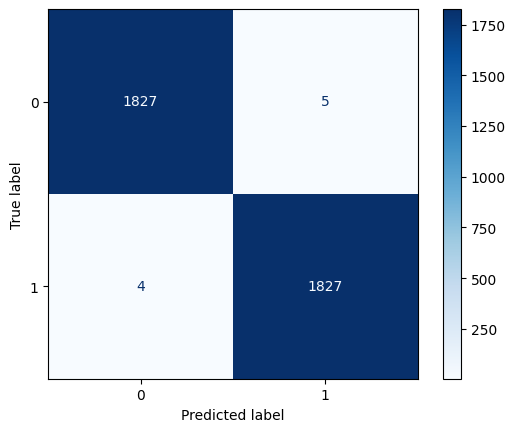

Accuracy:  0.9975429975429976
F1:  0.9975429975429976
Precison:  0.9972707423580786
Recall:  0.997815401419989


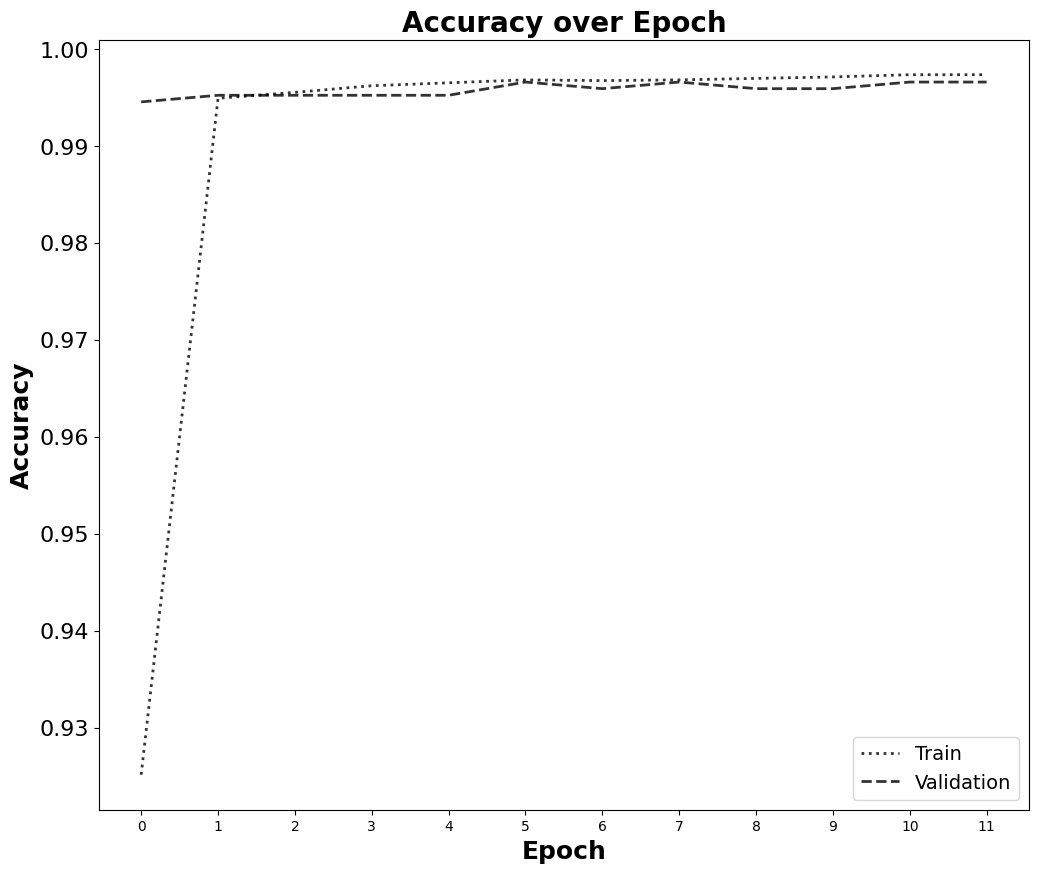

<Figure size 640x480 with 0 Axes>

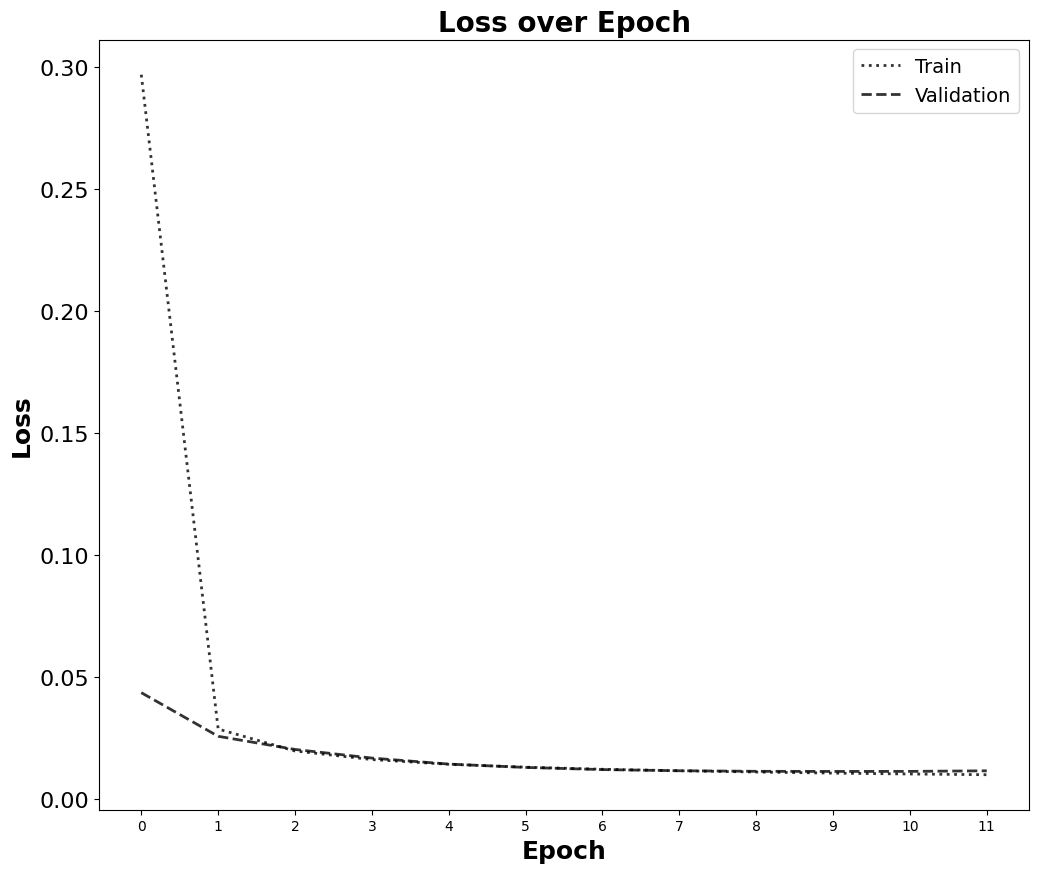

<Figure size 640x480 with 0 Axes>

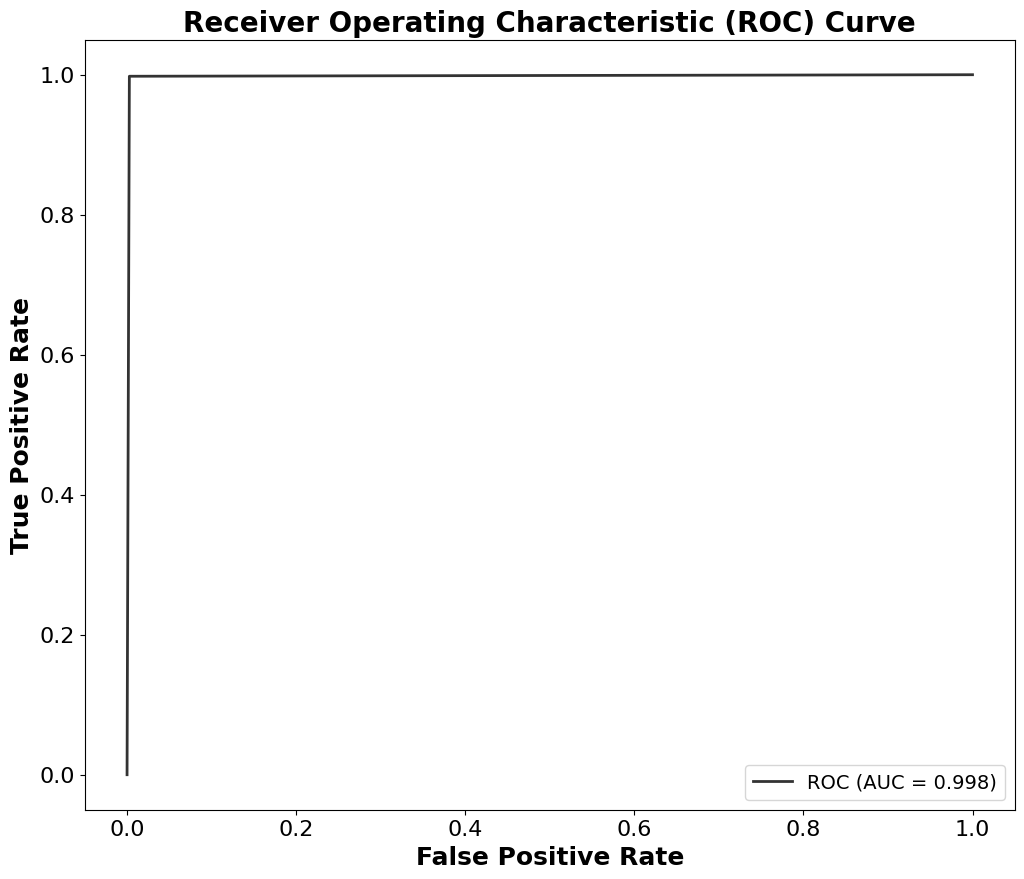

In [14]:
tf.random.set_seed(42)
self_defined_model = mlp_model(X_train.shape[1], Y_train)

predictions = self_defined_model(X_test)
print('Prediction: ', predictions)
print("Y_train: \n", type(Y_train), Y_train)
history = mlp_model_train(self_defined_model,
                X_train, Y_train,
                0.1, # Validation Split
                64, # Batch Size
                100 # Epoch Count
                )

print("history keys: ", history.history.keys())
# ============== Evaluation of the model with actual instances ==============

print("Performance when using actual testing instances")
predictions = model_eval(self_defined_model, X_test, Y_test)
plot_acc(Y_test, history, 1)
plot_loss(Y_test, history, 1)
plot_roc(Y_test, predictions, 1)

MLP model training and evaluating for CSECICIDS2018_improved

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 42)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,419 (21.17 KB)

 Trainable params: 5,419 (21.17 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5083269 ]
 [0.4923218 ]
 [0.4983483 ]
 ...
 [0.49455884]
 [0.48868155]
 [0.49601966]], shape=(3688, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[6.36979986e-01 2.51408045e-01 1.75006179e-01 ... 0.00000000e+00
  1.09040128e-03 0.00000000e+00]
 [5.26929544e-01 8.35336824e-05 9.79278483e-01 ... 0.00000000e+00
  6.10153579e-03 0.00000000e+00]
 [7.88956989e-01 1.77941572e-05 1.60583337e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.28545859e-01 6.09614644e-05 7.49500019e-04 ... 0.00000000e+00
  2.55496552e-01 0.00000000e+00]
 [5.97439931e-01 9.50669324e-05 1.43375004e-04 ... 0.00000000e+00
  8.93370548e-07 0.00000000e+00]
 [7.78054998e-01 7.90458641e-01 1.77450188e-01 ... 0.00000000e+00
  1.10562902e-03 0.00000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8916 - loss: 0.4093 - val_accuracy: 0.9959 - val_loss: 0.0269
Epoch 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 42)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,259 (63.52 KB)

 Trainable params: 5,419 (21.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,840 (42.35 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
classification_report
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1688
         1.0     1.0000    1.0000    1.0000      2000

    accuracy                         1.0000      3688
   macro avg     1.0000    1.0000    1.0000      3688
weighted avg     1.0000    1.0000    1.0000      3688

Confusion Matrix:
 [[1688    0]
 [   0 2000]]
labels =  None


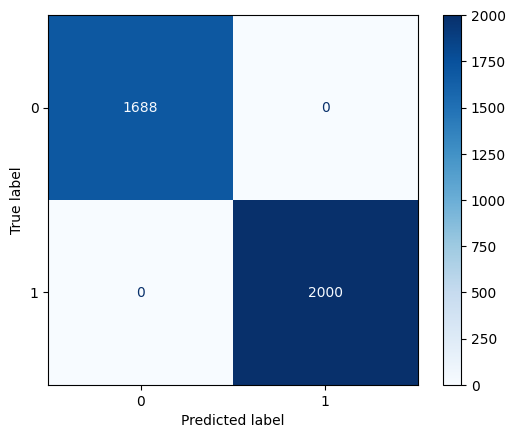

Accuracy:  1.0
F1:  1.0
Precison:  1.0
Recall:  1.0


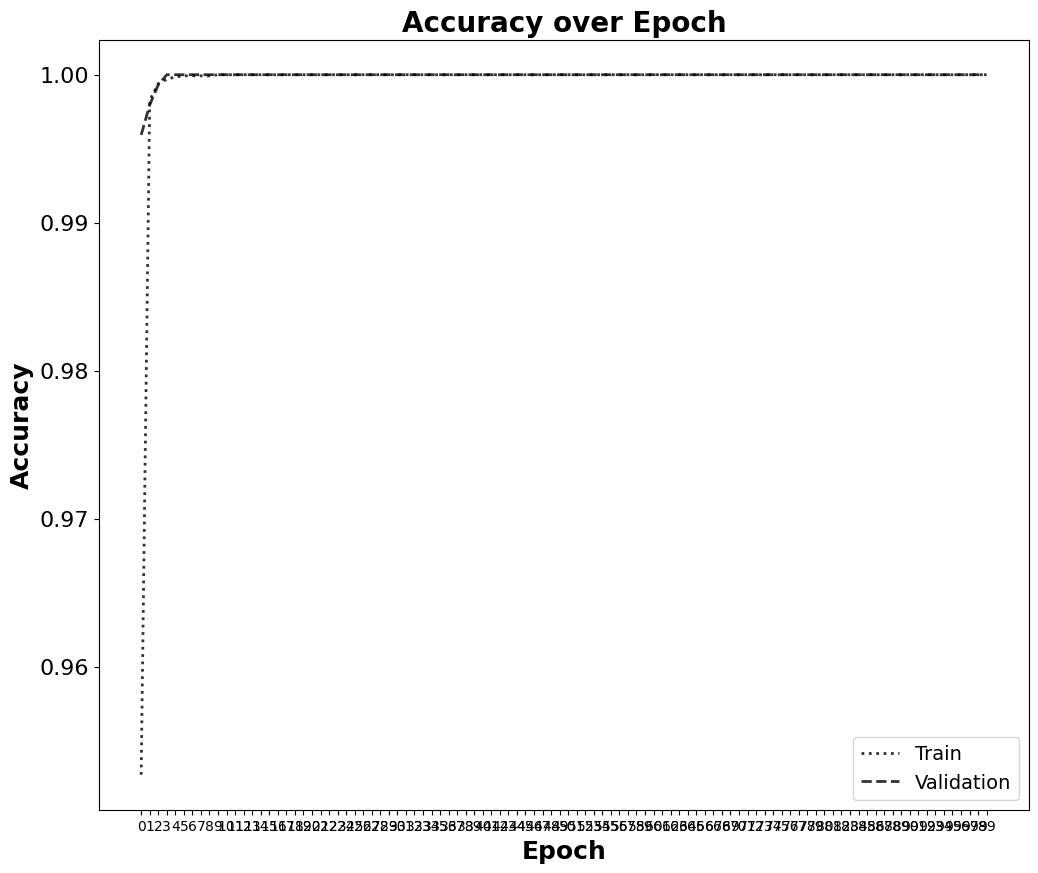

<Figure size 640x480 with 0 Axes>

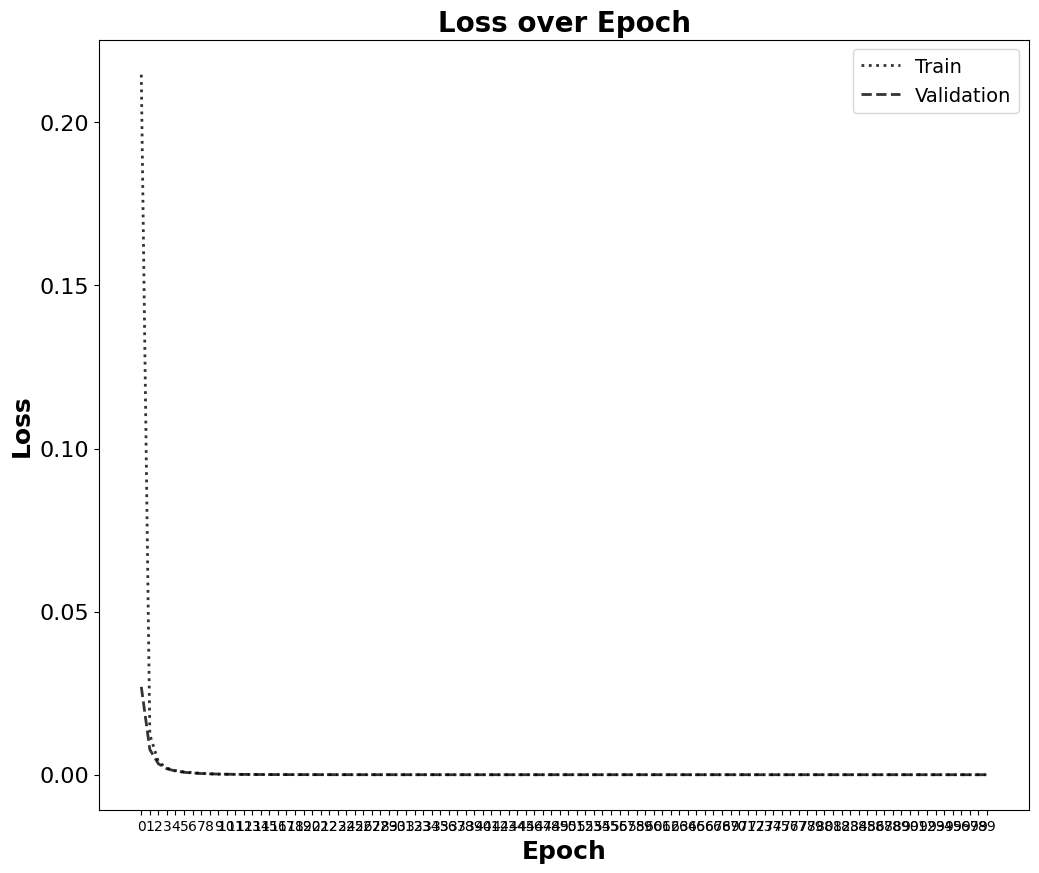

<Figure size 640x480 with 0 Axes>

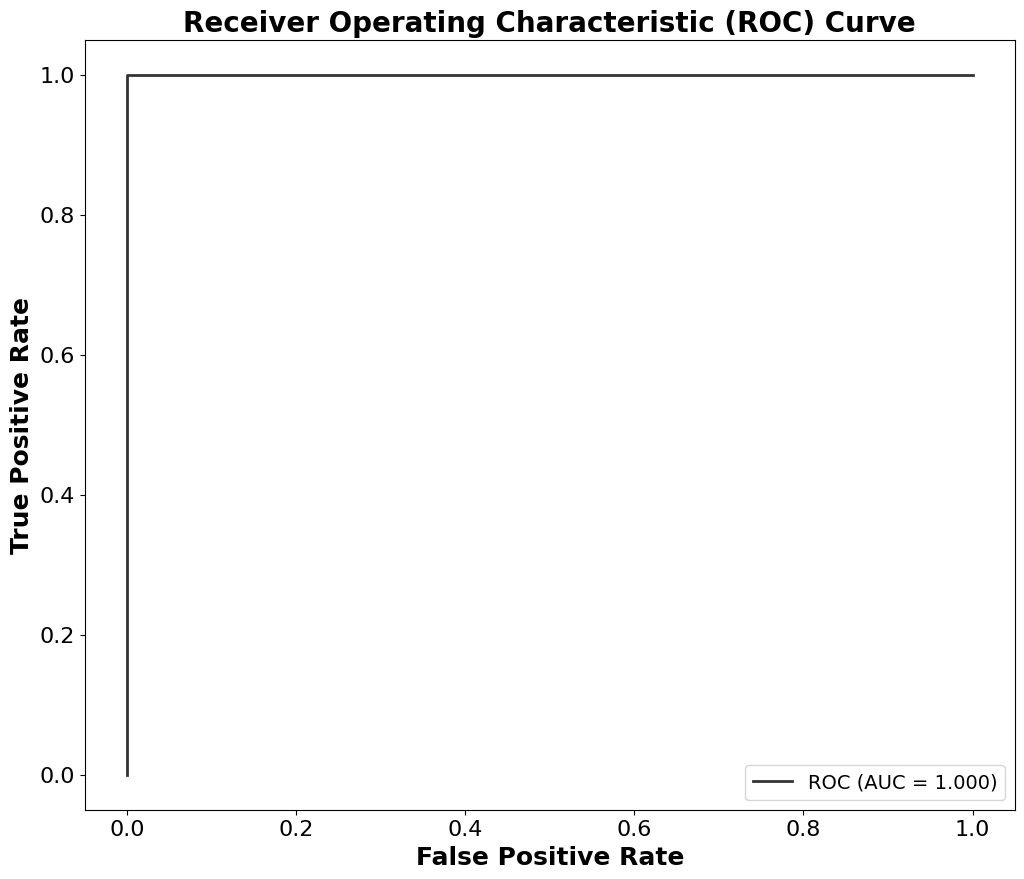

In [15]:
tf.random.set_seed(42)
csecicids2018_self_defined_model = mlp_model(csecicids2018_X_train.shape[1], csecicids2018_Y_train)

predictions = csecicids2018_self_defined_model(csecicids2018_X_test)
print('Prediction: ', predictions)

# ============== Train the model ==============
print("X_train: \n", type(csecicids2018_X_train), csecicids2018_X_train)
print("Y_train: \n", type(csecicids2018_Y_train), csecicids2018_Y_train)
history = mlp_model_train(csecicids2018_self_defined_model,
                csecicids2018_X_train, csecicids2018_Y_train,
                0.1, # Validation Split
                64, # Batch Size
                100 # Epoch Count
                )

print("history keys: ", history.history.keys())
# ============== Evaluation of the model with actual instances ==============

print("Performance when using actual testing instances")
predictions = model_eval(csecicids2018_self_defined_model, csecicids2018_X_test, csecicids2018_Y_test)
plot_acc(csecicids2018_Y_test, history, 1)
plot_loss(csecicids2018_Y_test, history, 1)
plot_roc(csecicids2018_Y_test, predictions, 1)

### More MLPs

In [16]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test):
  predictions = model(x_test)
  print('Prediction: ', predictions)

  # ============== Train the model ==============
  print("X_train: \n", type(x_train), x_train)
  print("Y_train: \n", type(y_train), y_train)
  history = mlp_model_train(model,
                x_train, y_train,
                0.1, # Validation Split
                64, # Batch Size
                100 # Epoch Count
                )

  print("history keys: ", history.history.keys())
  # ============== Evaluation of the model with actual instances ==============

  print("Performance when using actual testing instances")
  predictions = model_eval(model, x_test, y_test)
  plot_acc(y_test, history, 1)
  plot_loss(y_test, history, 1)
  plot_roc(y_test, predictions, 1)

3 hidden layers

In [17]:
def generate_mlp_model_3_hidden_layers(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=round(input_dim/2),
                    activation='relu',
                    input_shape=(input_dim,))) # layer 1
    model.add(Dense(units=round(input_dim/2), activation='relu')) # layer 2
    model.add(Dense(units=round(input_dim/2), activation='relu')) # layer 3

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,003 (7.82 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5583301 ]
 [0.53848517]
 [0.5722247 ]
 ...
 [0.54689664]
 [0.51946837]
 [0.45286536]], shape=(3663, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7189 - loss: 0.5010 - val_accuracy: 0.9945 - val_loss: 0.0321
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.021

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
classification_report
               precision    recall  f1-score   support

           0     0.9978    0.9962    0.9970      1832
           1     0.9962    0.9978    0.9970      1831

    accuracy                         0.9970      3663
   macro avg     0.9970    0.9970    0.9970      3663
weighted avg     0.9970    0.9970    0.9970      3663

Confusion Matrix:
 [[1825    7]
 [   4 1827]]
labels =  None


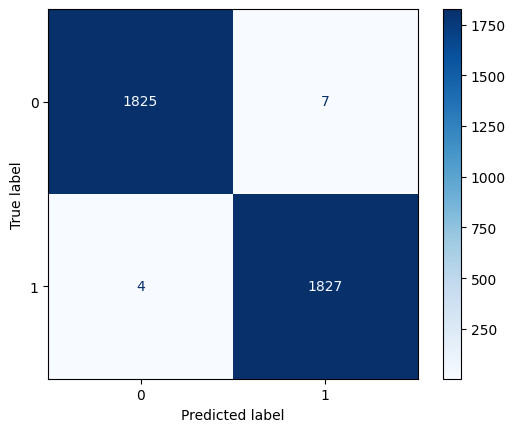

Accuracy:  0.996996996996997
F1:  0.9969986357435198
Precison:  0.9961832061068703
Recall:  0.997815401419989


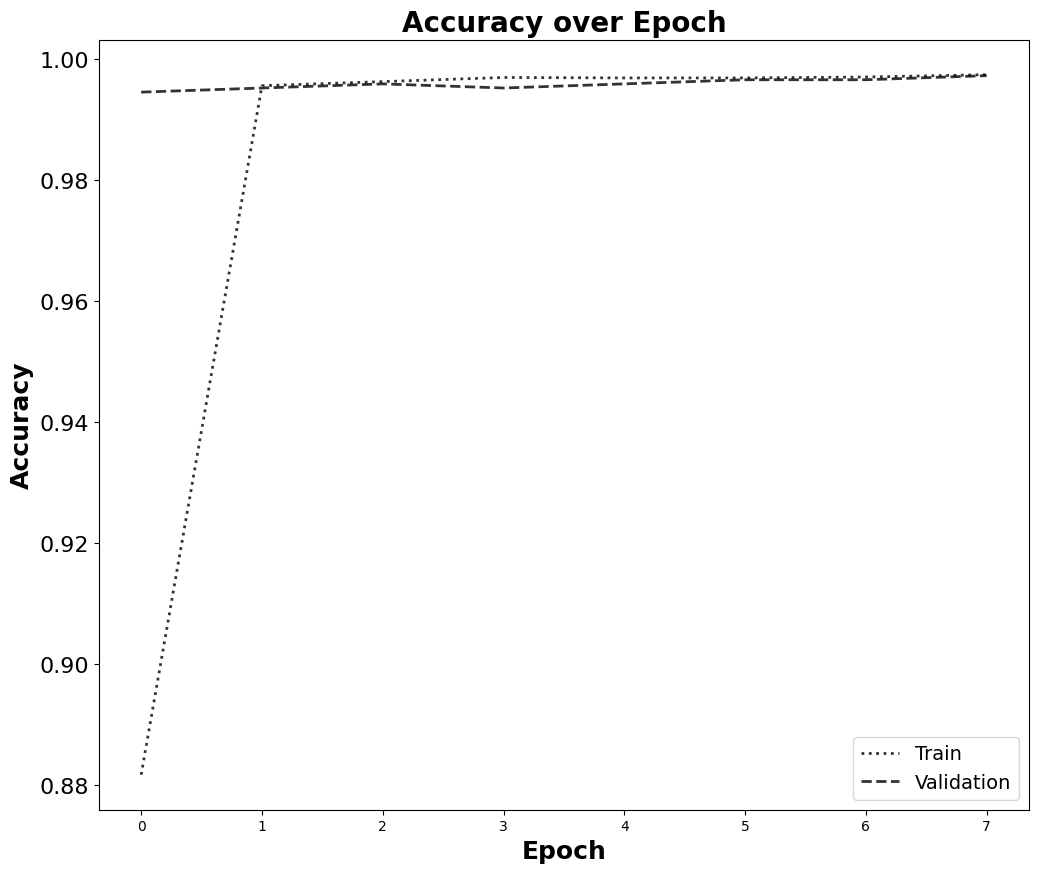

<Figure size 640x480 with 0 Axes>

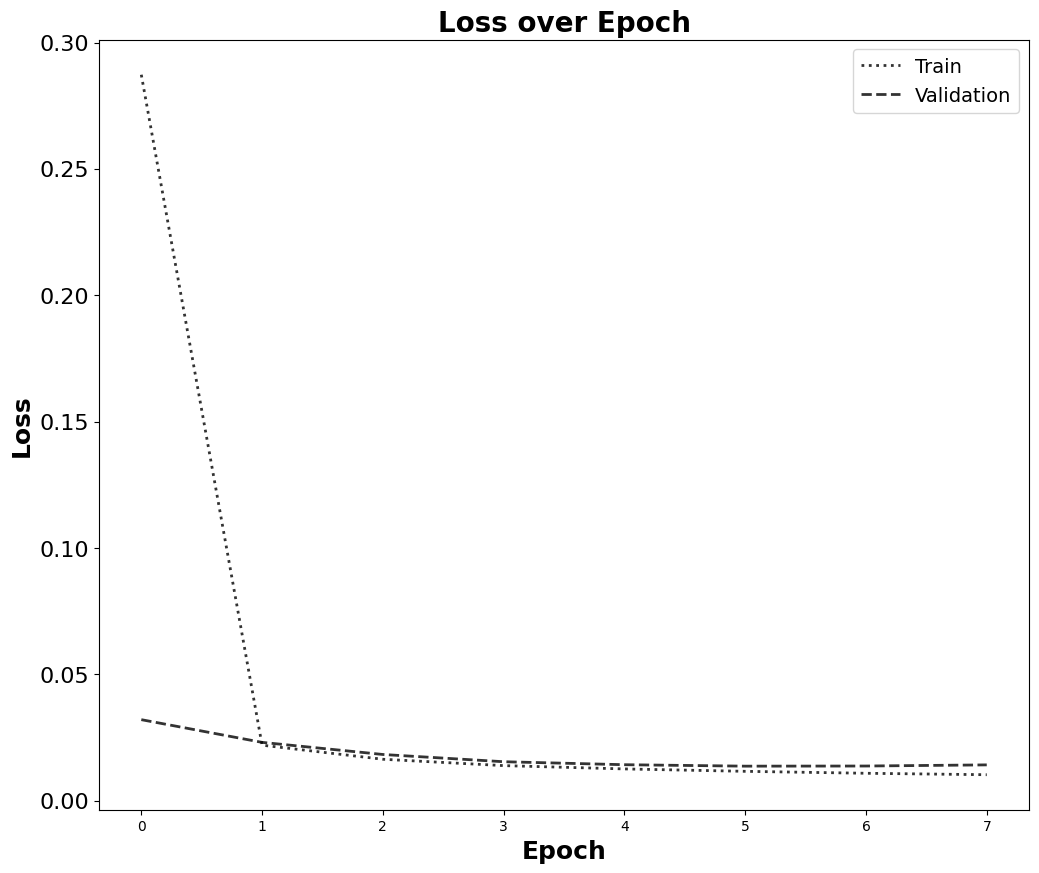

<Figure size 640x480 with 0 Axes>

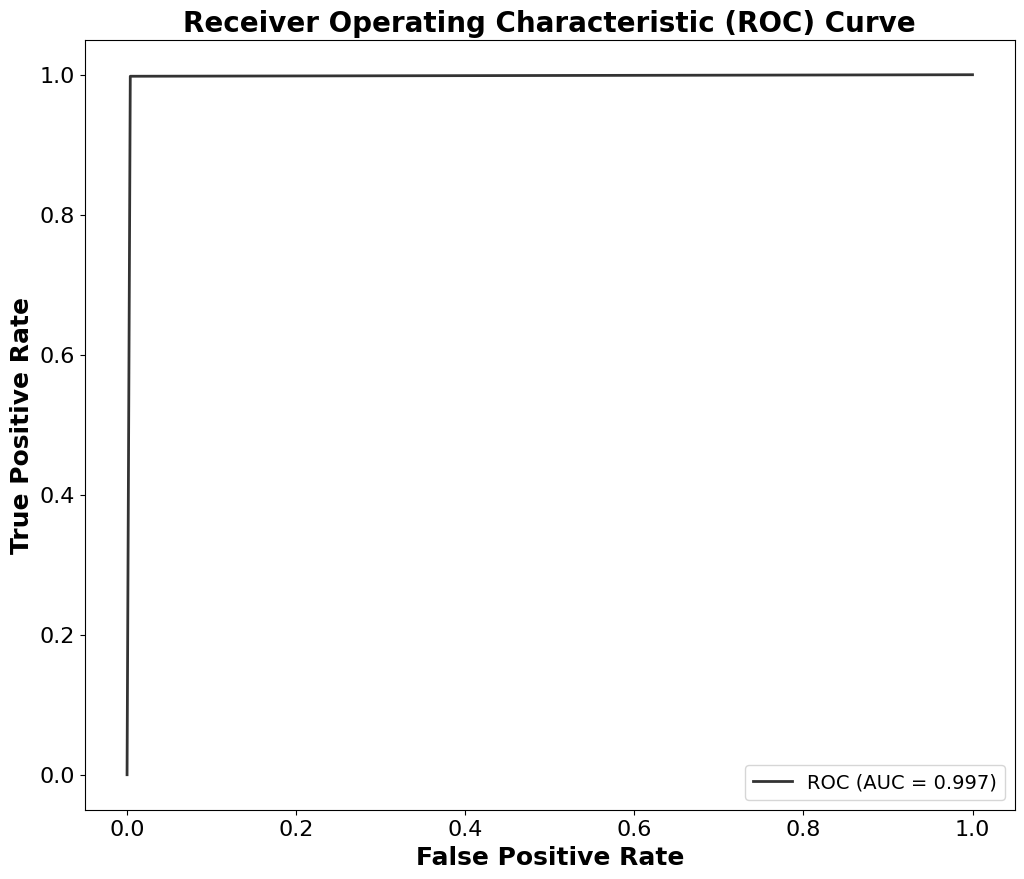

In [18]:
# TRAbID2017
model_3_hidden_layers = generate_mlp_model_3_hidden_layers(X_train.shape[1], Y_train)
train_and_evaluate(model_3_hidden_layers, X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 42)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,225 (28.22 KB)

 Trainable params: 7,225 (28.22 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.47326538]
 [0.46702814]
 [0.49427208]
 ...
 [0.45556608]
 [0.45496085]
 [0.42053092]], shape=(3688, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[6.36979986e-01 2.51408045e-01 1.75006179e-01 ... 0.00000000e+00
  1.09040128e-03 0.00000000e+00]
 [5.26929544e-01 8.35336824e-05 9.79278483e-01 ... 0.00000000e+00
  6.10153579e-03 0.00000000e+00]
 [7.88956989e-01 1.77941572e-05 1.60583337e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.28545859e-01 6.09614644e-05 7.49500019e-04 ... 0.00000000e+00
  2.55496552e-01 0.00000000e+00]
 [5.97439931e-01 9.50669324e-05 1.43375004e-04 ... 0.00000000e+00
  8.93370548e-07 0.00000000e+00]
 [7.78054998e-01 7.90458641e-01 1.77450188e-01 ... 0.00000000e+00
  1.10562902e-03 0.00000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8835 - loss: 0.3386 - val_accuracy: 0.9973 - val_loss: 0.0072
Epoch 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 42)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,677 (84.68 KB)

 Trainable params: 7,225 (28.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,452 (56.46 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
classification_report
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1688
         1.0     1.0000    1.0000    1.0000      2000

    accuracy                         1.0000      3688
   macro avg     1.0000    1.0000    1.0000      3688
weighted avg     1.0000    1.0000    1.0000      3688

Confusion Matrix:
 [[1688    0]
 [   0 2000]]
labels =  None


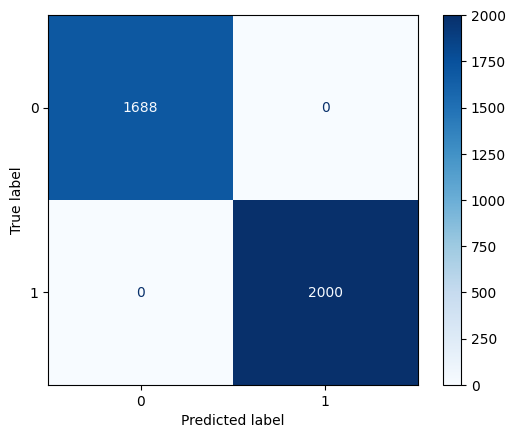

Accuracy:  1.0
F1:  1.0
Precison:  1.0
Recall:  1.0


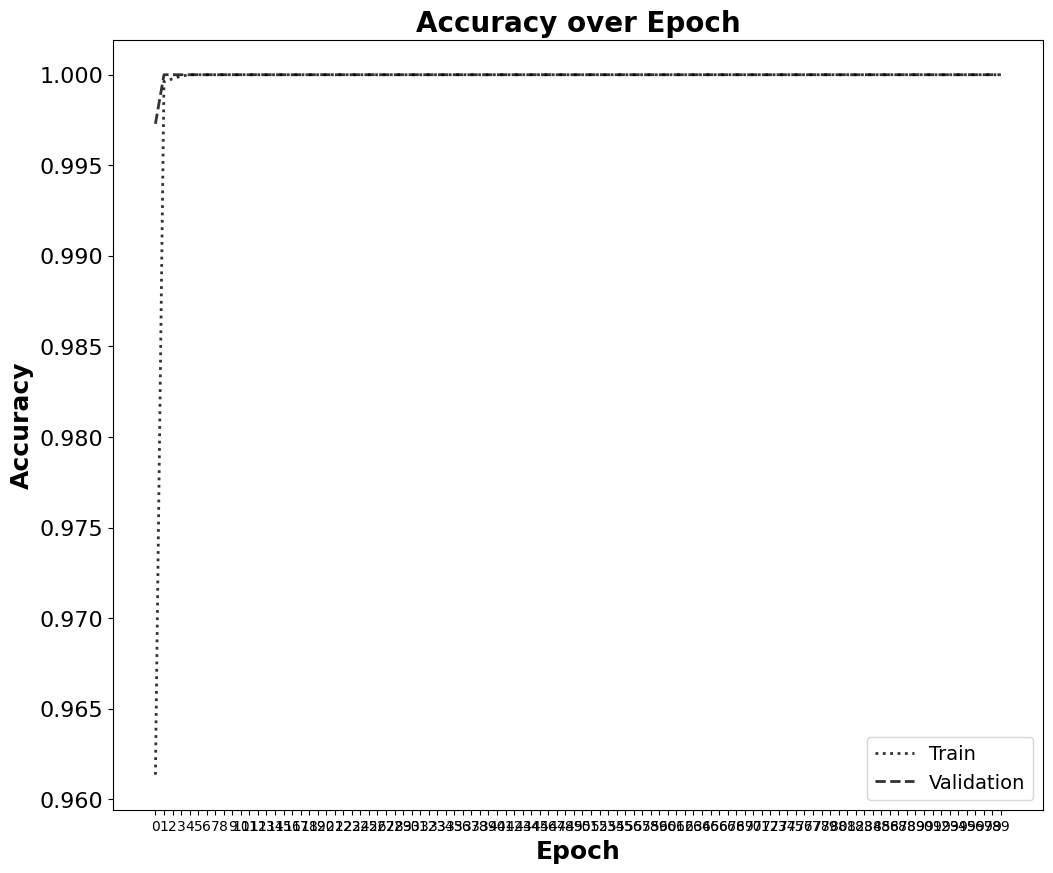

<Figure size 640x480 with 0 Axes>

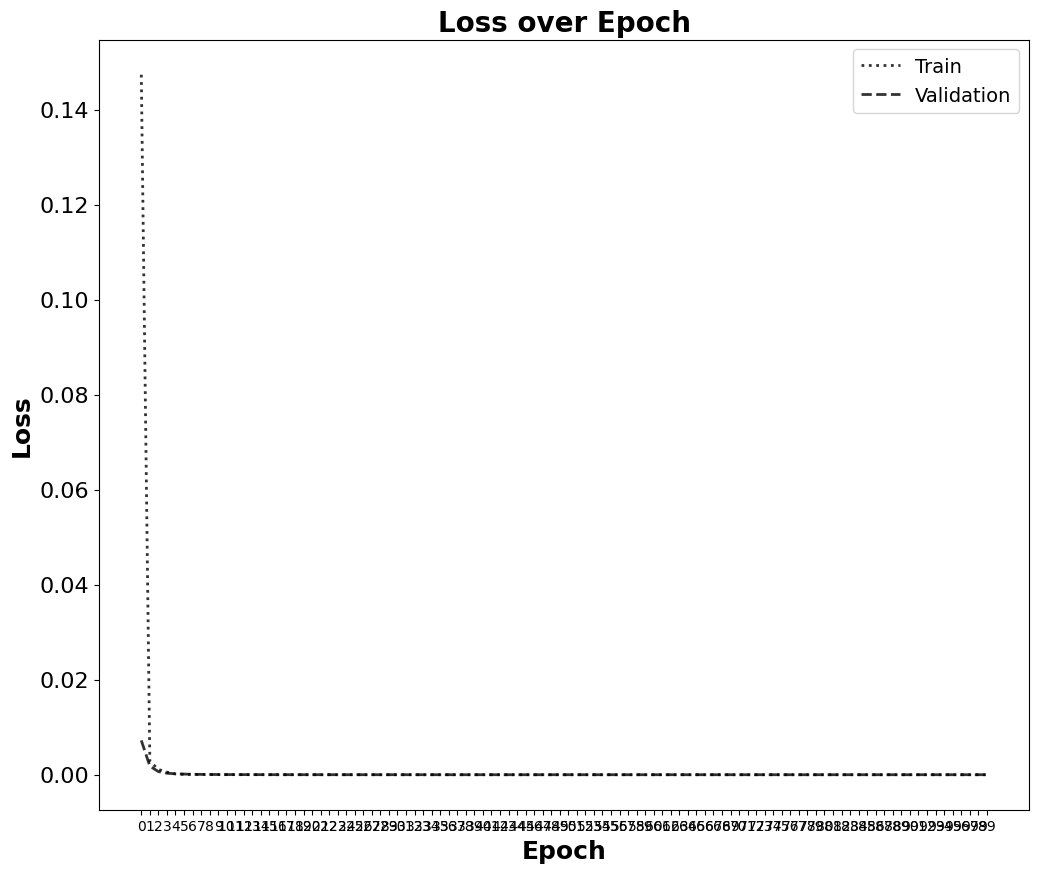

<Figure size 640x480 with 0 Axes>

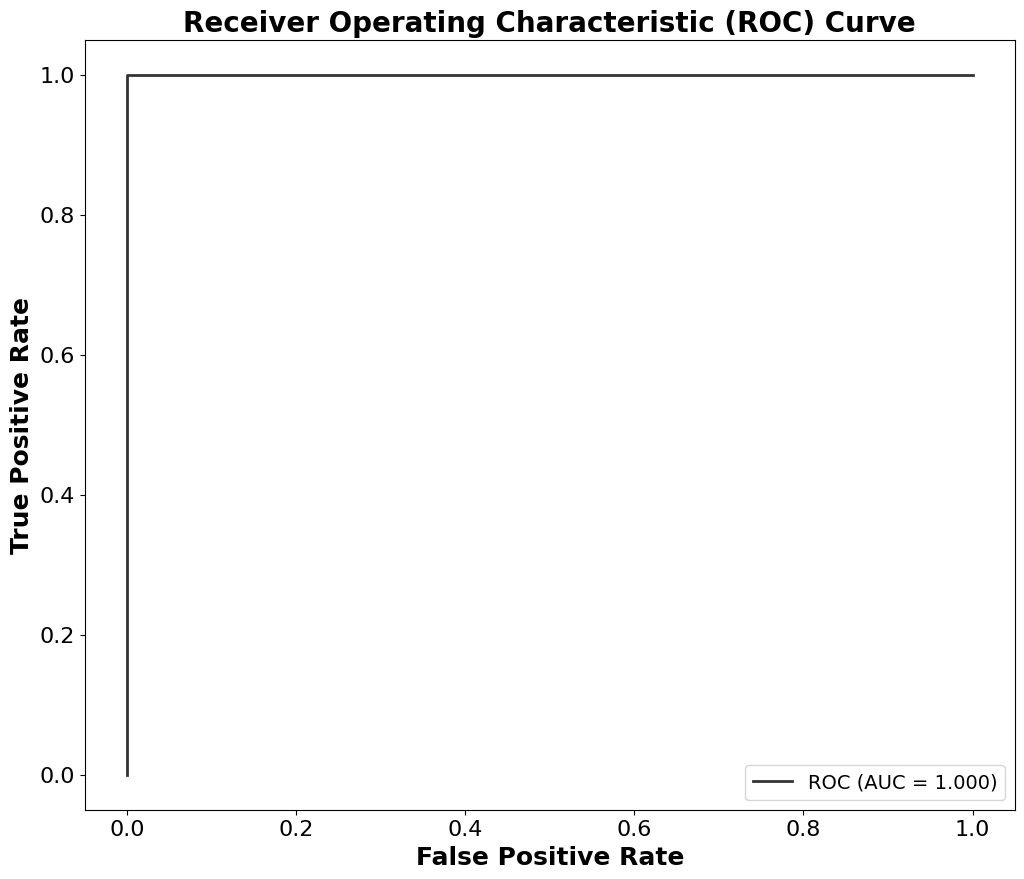

In [19]:
# CSECICIDS2018_improved
csecicids2018_model_3_hidden_layers = generate_mlp_model_3_hidden_layers(csecicids2018_X_train.shape[1], csecicids2018_Y_train)
train_and_evaluate(csecicids2018_model_3_hidden_layers, csecicids2018_X_train, csecicids2018_Y_train, csecicids2018_X_test, csecicids2018_Y_test)

4 hidden layers

In [20]:
def generate_mlp_model_4_hidden_layers(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=round(input_dim/2),
                    activation='relu',
                    input_shape=(input_dim,))) # layer 1
    model.add(Dense(units=round(input_dim/2), activation='relu')) # layer 2
    model.add(Dense(units=round(input_dim/2), activation='relu')) # layer 3
    model.add(Dense(units=round(input_dim/2), activation='relu')) # layer 4

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,509 (9.80 KB)

 Trainable params: 2,509 (9.80 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5237442 ]
 [0.50584656]
 [0.50753784]
 ...
 [0.5129278 ]
 [0.5196737 ]
 [0.52896553]], shape=(3663, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8867 - loss: 0.4369 - val_accuracy: 0.9952 - val_loss: 0.0257
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.01

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 22)             │           968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 22)             │           506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,529 (29.41 KB)

 Trainable params: 2,509 (9.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,020 (19.61 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
classification_report
               precision    recall  f1-score   support

           0     0.9978    0.9967    0.9973      1832
           1     0.9967    0.9978    0.9973      1831

    accuracy                         0.9973      3663
   macro avg     0.9973    0.9973    0.9973      3663
weighted avg     0.9973    0.9973    0.9973      3663

Confusion Matrix:
 [[1826    6]
 [   4 1827]]
labels =  None


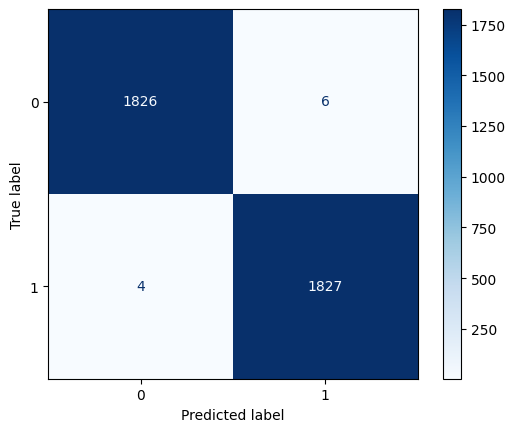

Accuracy:  0.9972699972699973
F1:  0.9972707423580786
Precison:  0.9967266775777414
Recall:  0.997815401419989


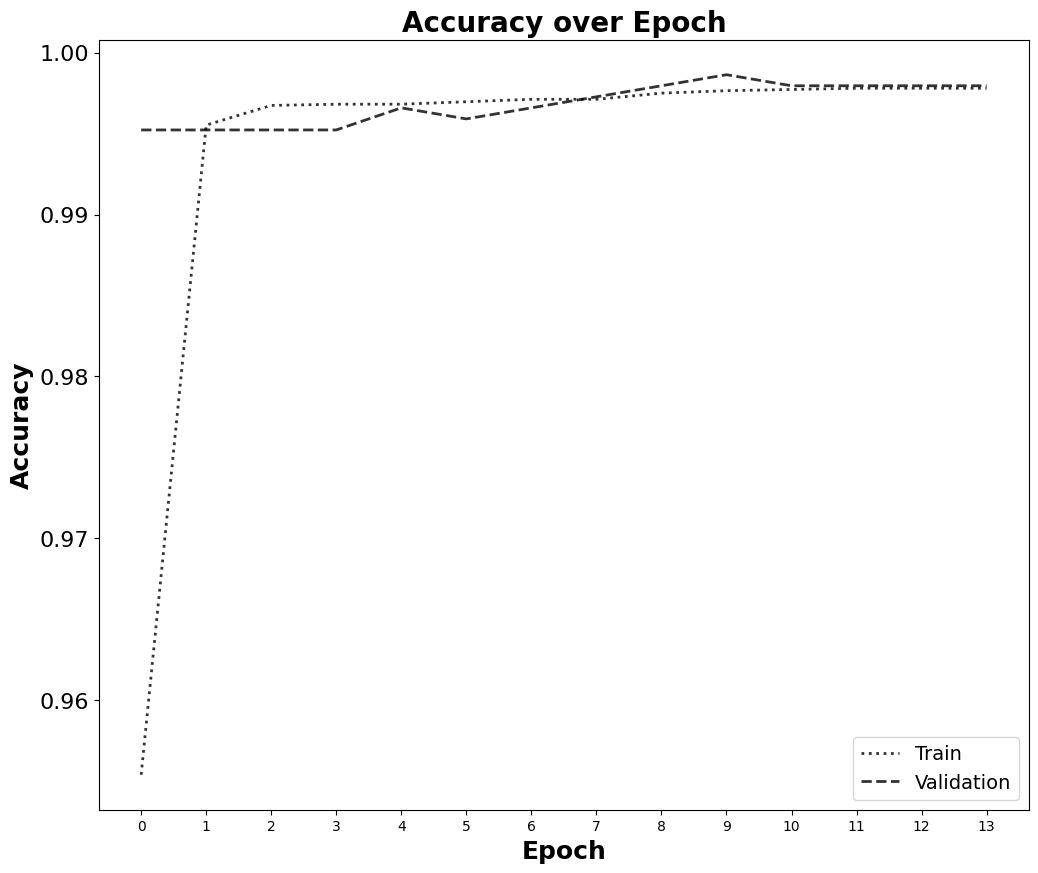

<Figure size 640x480 with 0 Axes>

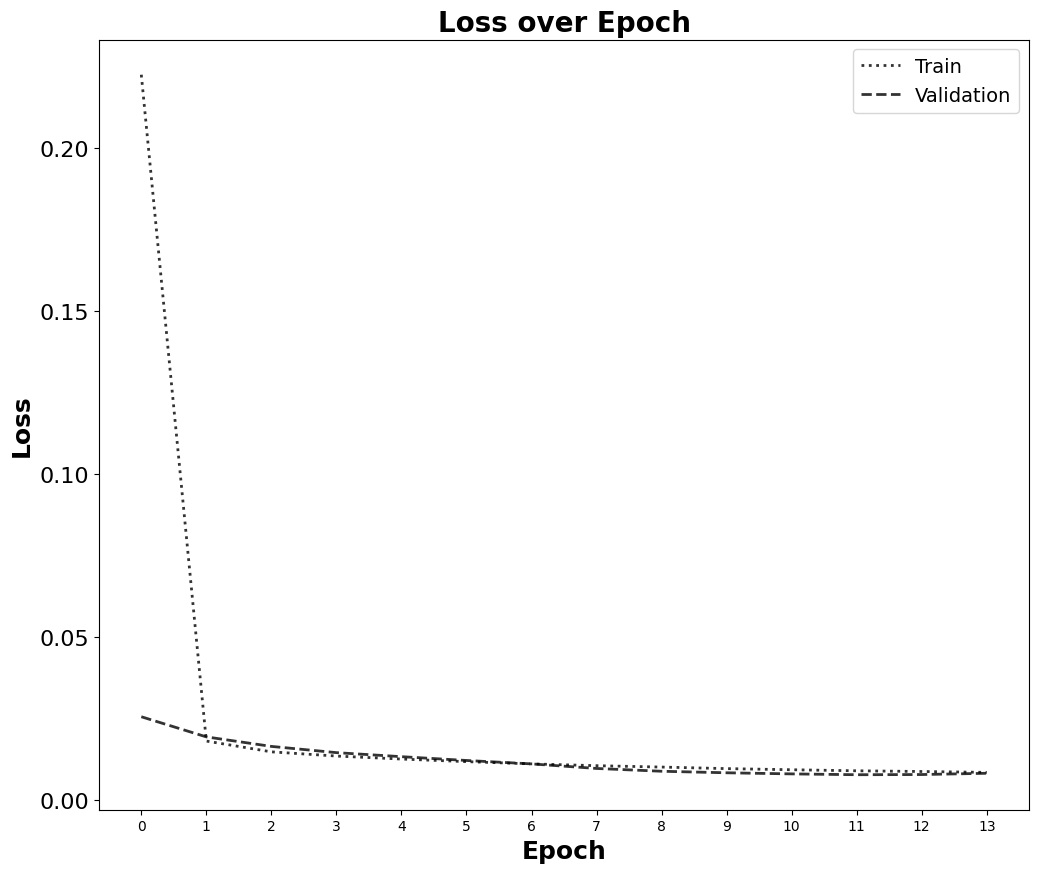

<Figure size 640x480 with 0 Axes>

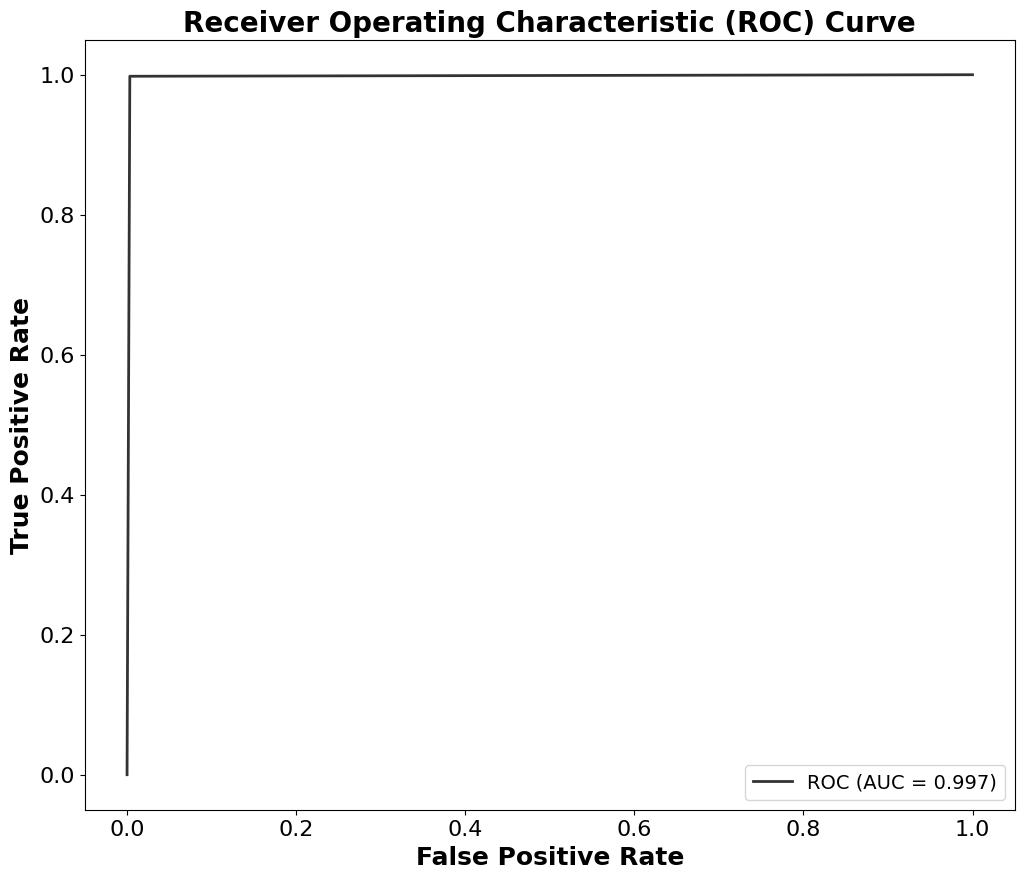

In [21]:
# TRAbID2017
model_4_hidden_layers = generate_mlp_model_4_hidden_layers(X_train.shape[1], Y_train)
train_and_evaluate(model_4_hidden_layers, X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 42)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,031 (35.28 KB)

 Trainable params: 9,031 (35.28 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5262971 ]
 [0.50275356]
 [0.5019458 ]
 ...
 [0.5162232 ]
 [0.5181601 ]
 [0.5185805 ]], shape=(3688, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[6.36979986e-01 2.51408045e-01 1.75006179e-01 ... 0.00000000e+00
  1.09040128e-03 0.00000000e+00]
 [5.26929544e-01 8.35336824e-05 9.79278483e-01 ... 0.00000000e+00
  6.10153579e-03 0.00000000e+00]
 [7.88956989e-01 1.77941572e-05 1.60583337e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.28545859e-01 6.09614644e-05 7.49500019e-04 ... 0.00000000e+00
  2.55496552e-01 0.00000000e+00]
 [5.97439931e-01 9.50669324e-05 1.43375004e-04 ... 0.00000000e+00
  8.93370548e-07 0.00000000e+00]
 [7.78054998e-01 7.90458641e-01 1.77450188e-01 ... 0.00000000e+00
  1.10562902e-03 0.00000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9062 - loss: 0.3206 - val_accuracy: 0.9993 - val_loss: 0.0027
Epoch 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 42)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,095 (105.84 KB)

 Trainable params: 9,031 (35.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,064 (70.57 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
classification_report
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1688
         1.0     1.0000    1.0000    1.0000      2000

    accuracy                         1.0000      3688
   macro avg     1.0000    1.0000    1.0000      3688
weighted avg     1.0000    1.0000    1.0000      3688

Confusion Matrix:
 [[1688    0]
 [   0 2000]]
labels =  None


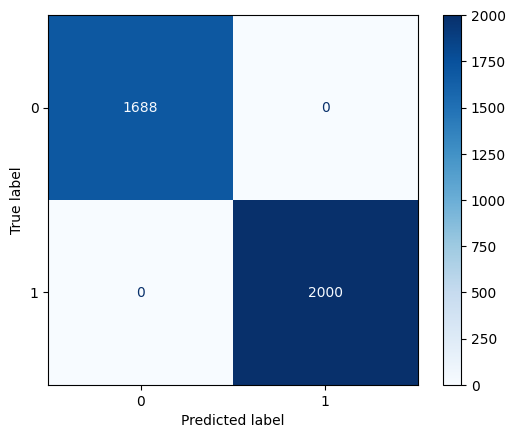

Accuracy:  1.0
F1:  1.0
Precison:  1.0
Recall:  1.0


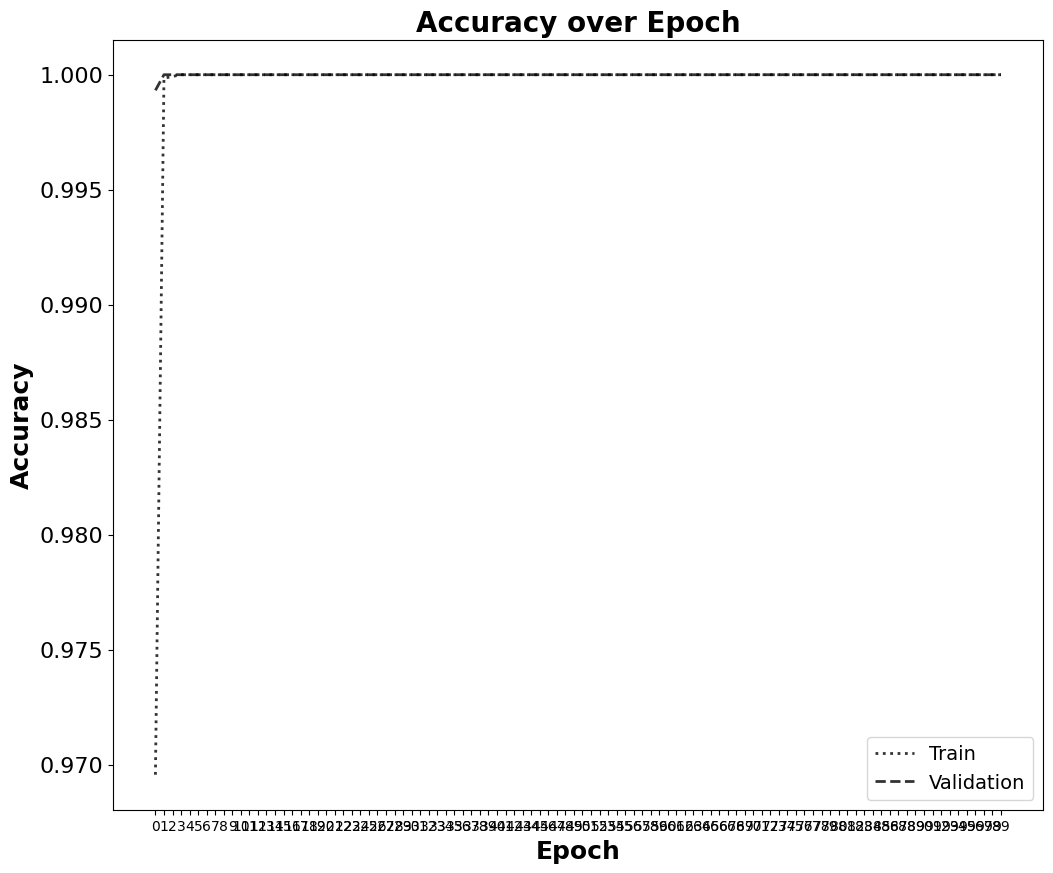

<Figure size 640x480 with 0 Axes>

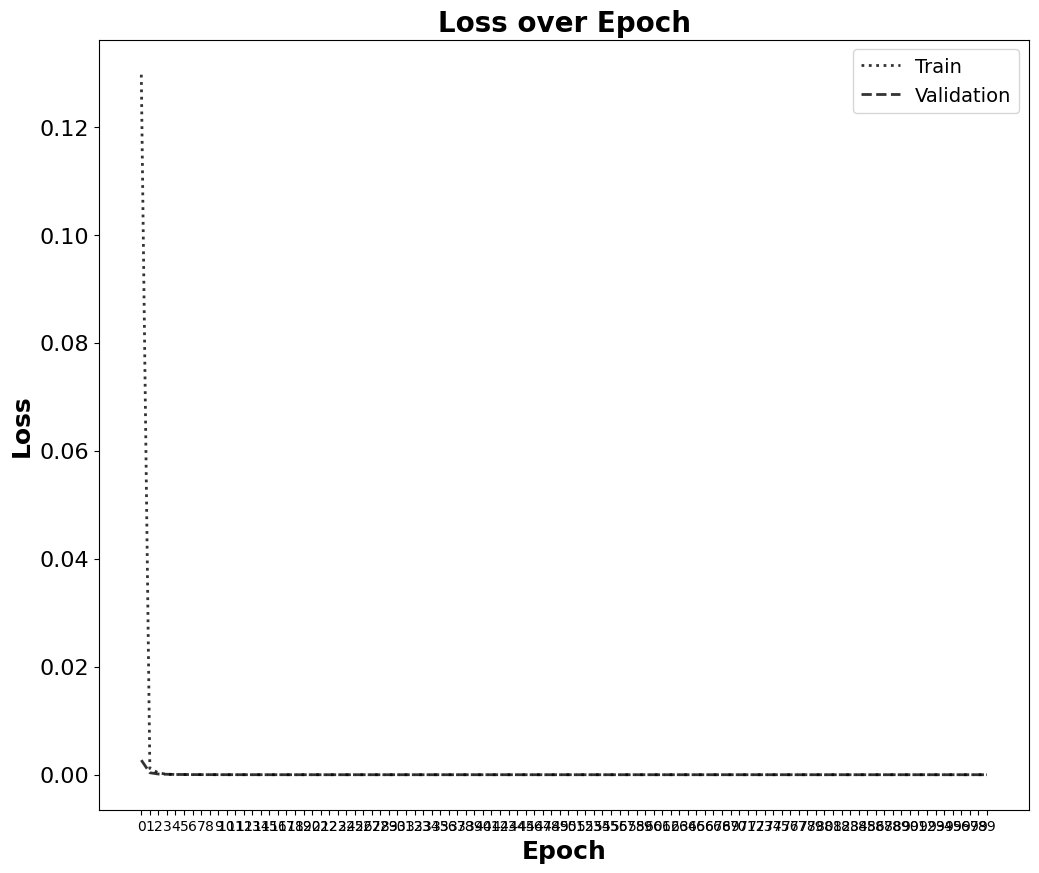

<Figure size 640x480 with 0 Axes>

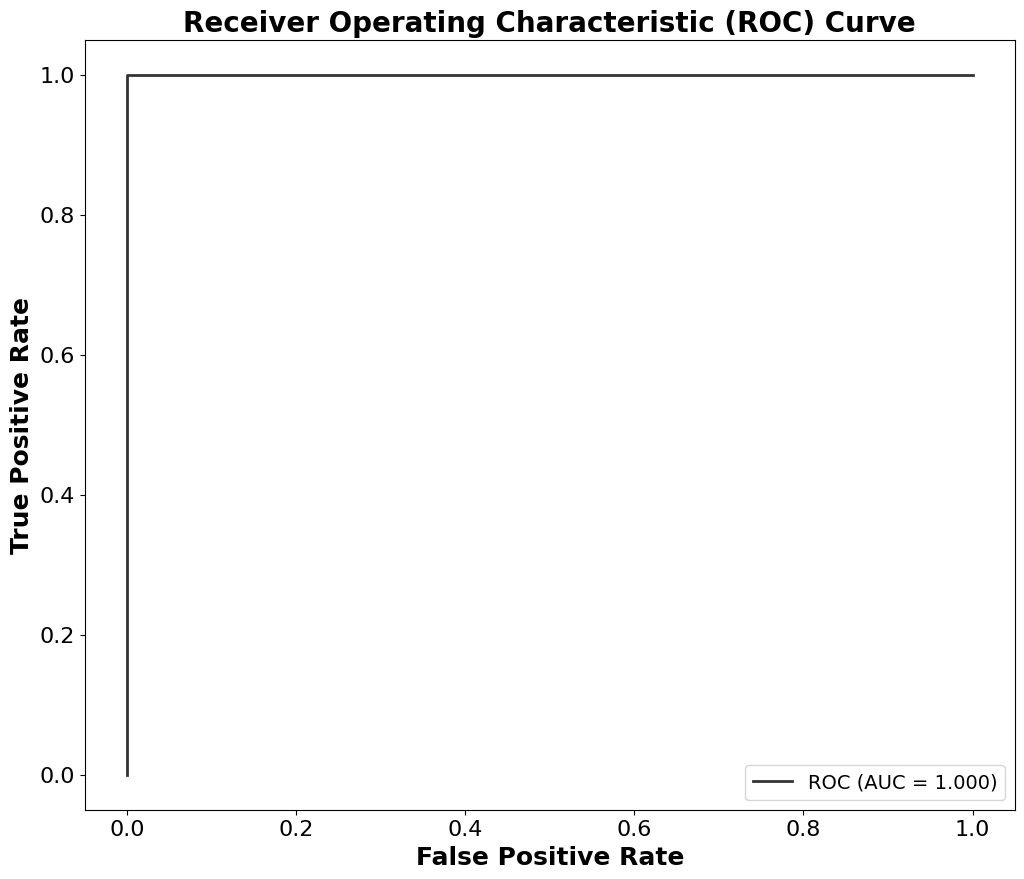

In [22]:
# CSECICIDS2018_improved
csecicids2018_model_4_hidden_layers = generate_mlp_model_4_hidden_layers(csecicids2018_X_train.shape[1], csecicids2018_Y_train)
train_and_evaluate(csecicids2018_model_4_hidden_layers, csecicids2018_X_train, csecicids2018_Y_train, csecicids2018_X_test, csecicids2018_Y_test)

2 hidden layers & 64 neurons in each layer

In [23]:
# Generate a multilayer perceptron  model or ANN
def generate_mlp_model_2_hidden_layers_64_neurons(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=64,
                    activation='relu',
                    input_shape=(input_dim,))) # layer 1
    model.add(Dense(units=64, activation='relu')) # layer2

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041 (27.50 KB)

 Trainable params: 7,041 (27.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.48592338]
 [0.49565208]
 [0.49058998]
 ...
 [0.50471807]
 [0.49539754]
 [0.4436419 ]], shape=(3663, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9251 - loss: 0.3785 - val_accuracy: 0.9952 - val_loss: 0.0232
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.01

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,125 (82.52 KB)

 Trainable params: 7,041 (27.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,084 (55.02 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
classification_report
               precision    recall  f1-score   support

           0     0.9978    0.9967    0.9973      1832
           1     0.9967    0.9978    0.9973      1831

    accuracy                         0.9973      3663
   macro avg     0.9973    0.9973    0.9973      3663
weighted avg     0.9973    0.9973    0.9973      3663

Confusion Matrix:
 [[1826    6]
 [   4 1827]]
labels =  None


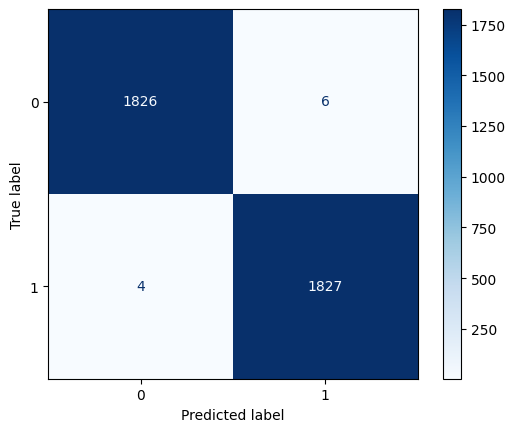

Accuracy:  0.9972699972699973
F1:  0.9972707423580786
Precison:  0.9967266775777414
Recall:  0.997815401419989


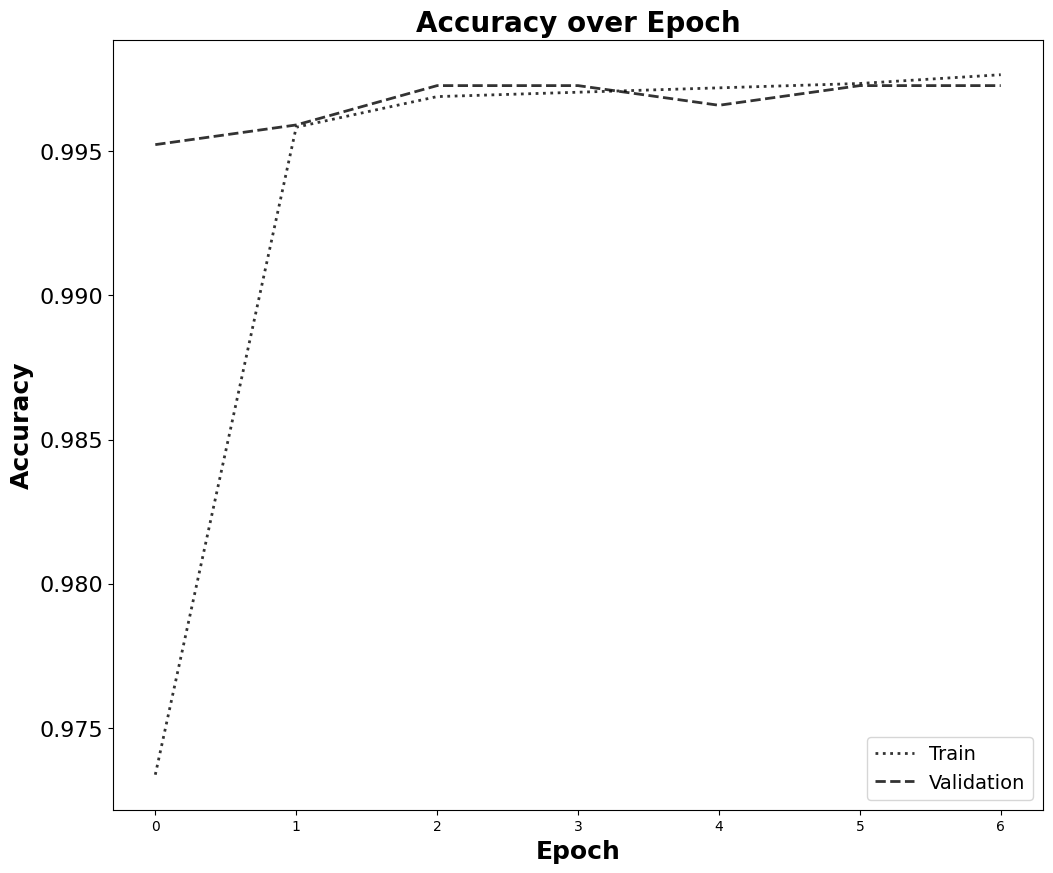

<Figure size 640x480 with 0 Axes>

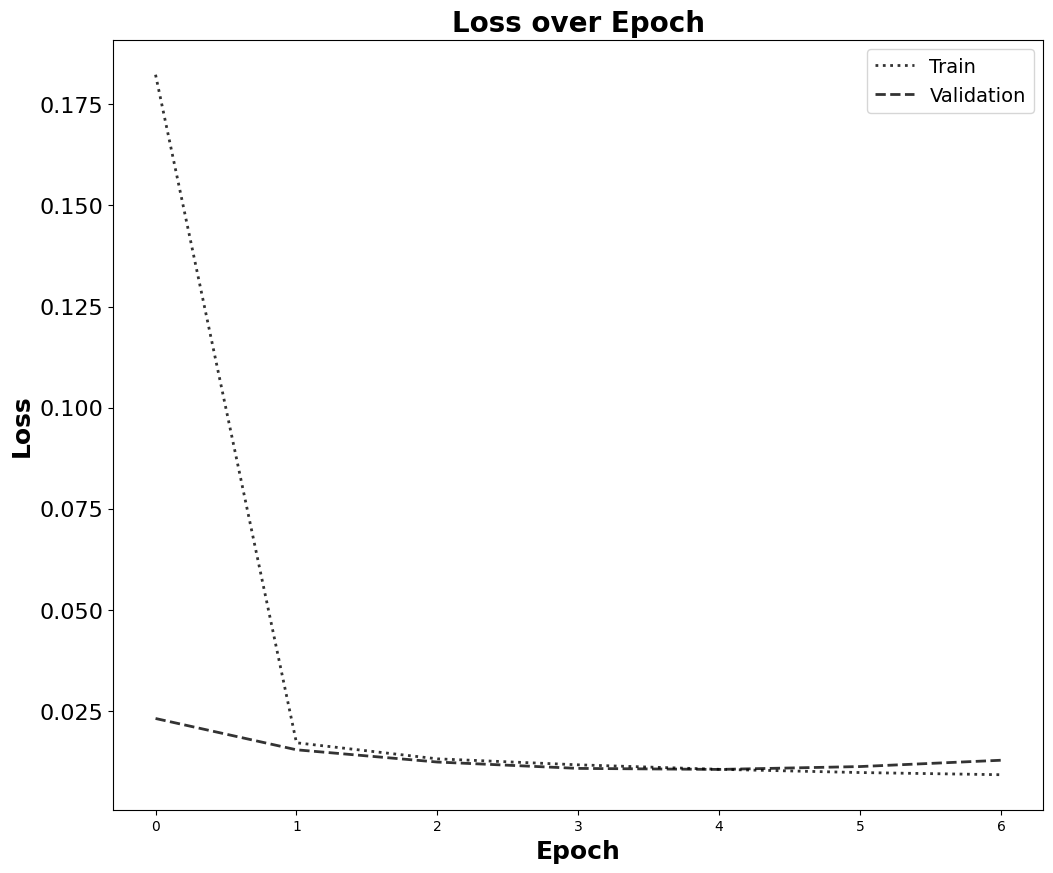

<Figure size 640x480 with 0 Axes>

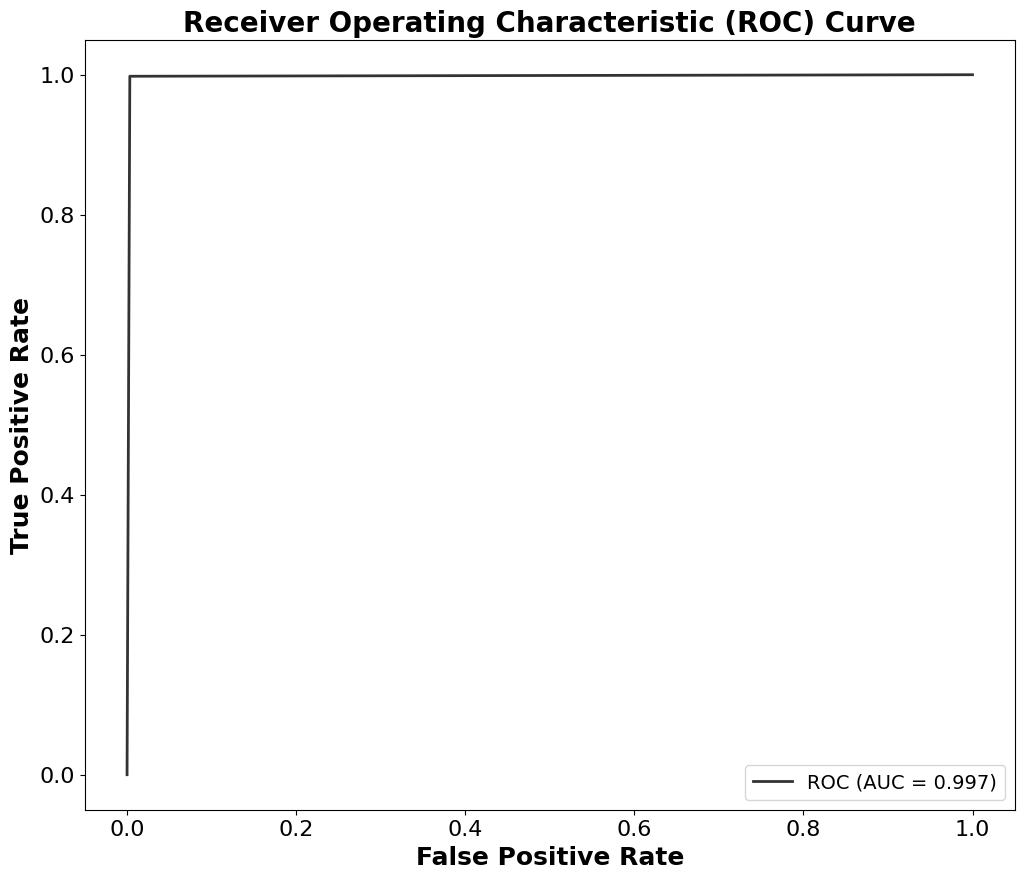

In [24]:
# TRAbID2017
model_2h64n = generate_mlp_model_2_hidden_layers_64_neurons(X_train.shape[1], Y_train)
train_and_evaluate(model_2h64n, X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,665 (37.75 KB)

 Trainable params: 9,665 (37.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5290284 ]
 [0.5288195 ]
 [0.53227884]
 ...
 [0.5421704 ]
 [0.54335535]
 [0.5677734 ]], shape=(3688, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[6.36979986e-01 2.51408045e-01 1.75006179e-01 ... 0.00000000e+00
  1.09040128e-03 0.00000000e+00]
 [5.26929544e-01 8.35336824e-05 9.79278483e-01 ... 0.00000000e+00
  6.10153579e-03 0.00000000e+00]
 [7.88956989e-01 1.77941572e-05 1.60583337e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.28545859e-01 6.09614644e-05 7.49500019e-04 ... 0.00000000e+00
  2.55496552e-01 0.00000000e+00]
 [5.97439931e-01 9.50669324e-05 1.43375004e-04 ... 0.00000000e+00
  8.93370548e-07 0.00000000e+00]
 [7.78054998e-01 7.90458641e-01 1.77450188e-01 ... 0.00000000e+00
  1.10562902e-03 0.00000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9031 - loss: 0.3141 - val_accuracy: 0.9966 - val_loss: 0.0158
Epoch 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,997 (113.27 KB)

 Trainable params: 9,665 (37.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,332 (75.52 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
classification_report
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1688
         1.0     1.0000    1.0000    1.0000      2000

    accuracy                         1.0000      3688
   macro avg     1.0000    1.0000    1.0000      3688
weighted avg     1.0000    1.0000    1.0000      3688

Confusion Matrix:
 [[1688    0]
 [   0 2000]]
labels =  None


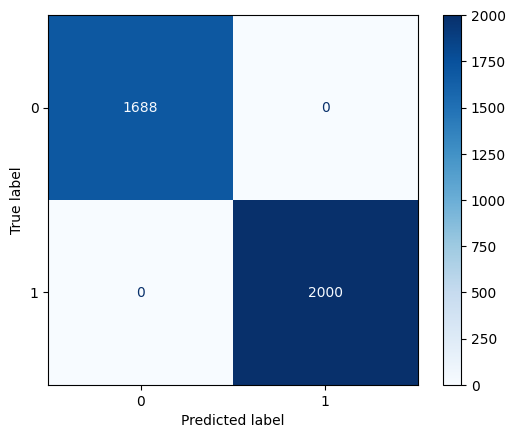

Accuracy:  1.0
F1:  1.0
Precison:  1.0
Recall:  1.0


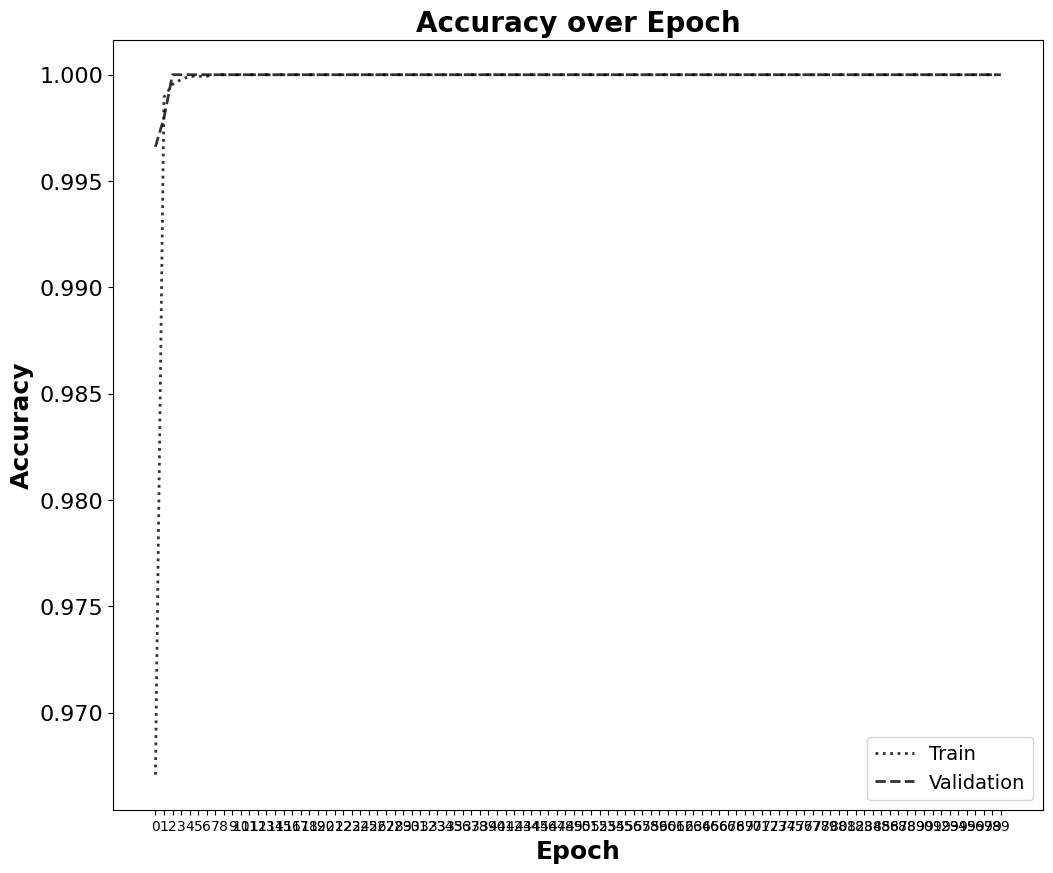

<Figure size 640x480 with 0 Axes>

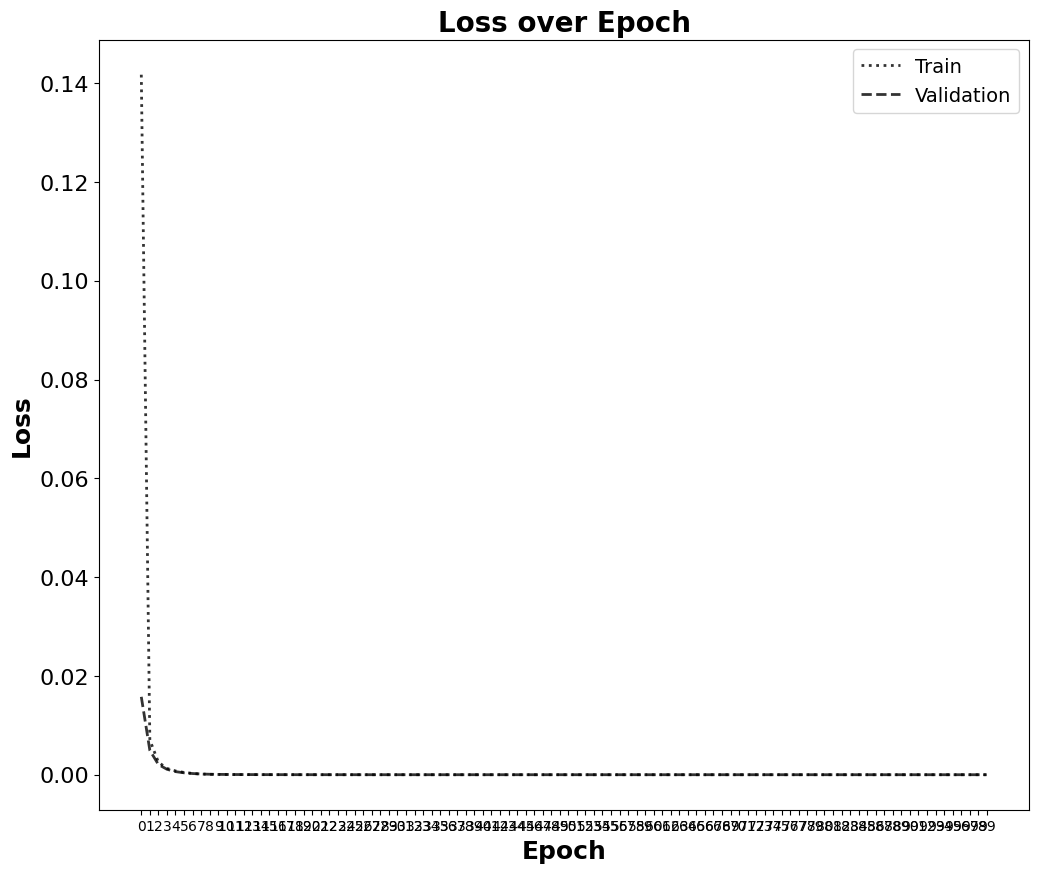

<Figure size 640x480 with 0 Axes>

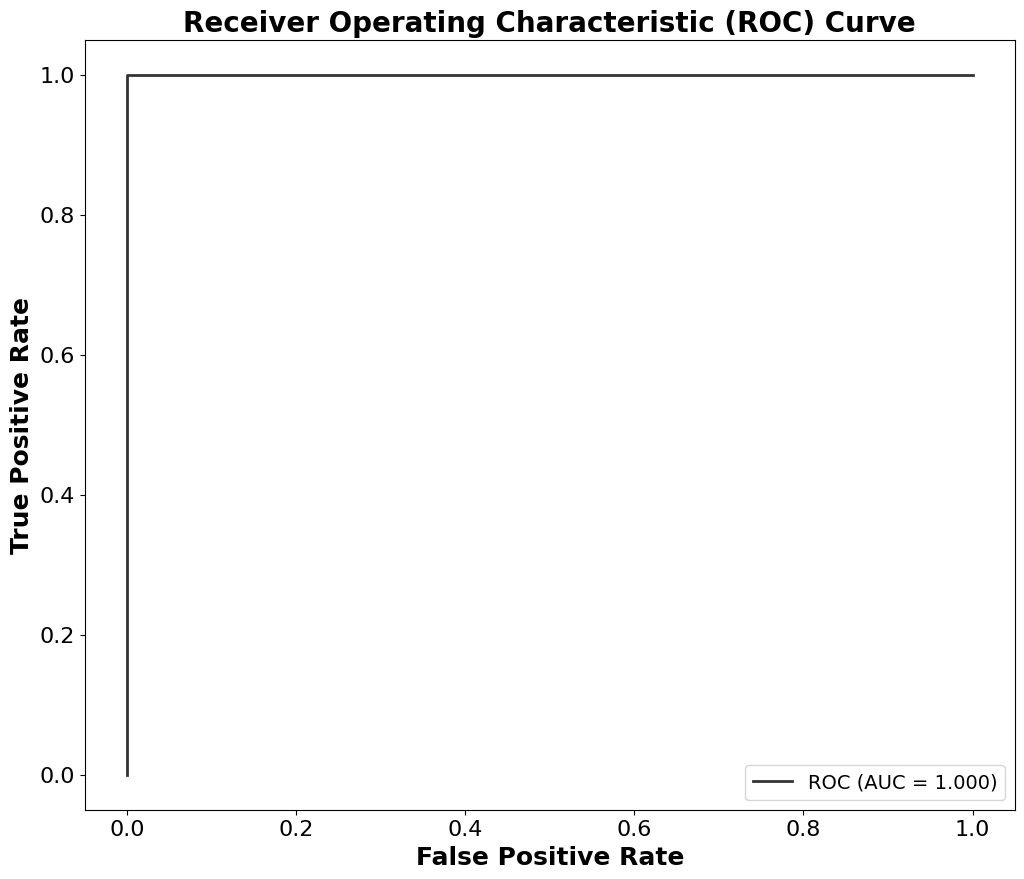

In [25]:
# CSECICIDS2018_improved
csecicids2018_model_2h64n = generate_mlp_model_2_hidden_layers_64_neurons(csecicids2018_X_train.shape[1], csecicids2018_Y_train)
train_and_evaluate(csecicids2018_model_2h64n, csecicids2018_X_train, csecicids2018_Y_train, csecicids2018_X_test, csecicids2018_Y_test)

3 hidden layers with 64 neurons in each layer

In [26]:
# Generate a multilayer perceptron  model or ANN
def generate_mlp_model_3_hidden_layers_64_neurons(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=64,
                    activation='relu',
                    input_shape=(input_dim,))) # layer 1
    model.add(Dense(units=64, activation='relu')) # layer2
    model.add(Dense(units=64, activation='relu')) # layer3

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,201 (43.75 KB)

 Trainable params: 11,201 (43.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.50815237]
 [0.5412843 ]
 [0.5320796 ]
 ...
 [0.5479014 ]
 [0.52939415]
 [0.6094148 ]], shape=(3663, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9394 - loss: 0.2750 - val_accuracy: 0.9959 - val_loss: 0.0190
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.013

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,605 (131.27 KB)

 Trainable params: 11,201 (43.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,404 (87.52 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
classification_report
               precision    recall  f1-score   support

           0     0.9978    0.9962    0.9970      1832
           1     0.9962    0.9978    0.9970      1831

    accuracy                         0.9970      3663
   macro avg     0.9970    0.9970    0.9970      3663
weighted avg     0.9970    0.9970    0.9970      3663

Confusion Matrix:
 [[1825    7]
 [   4 1827]]
labels =  None


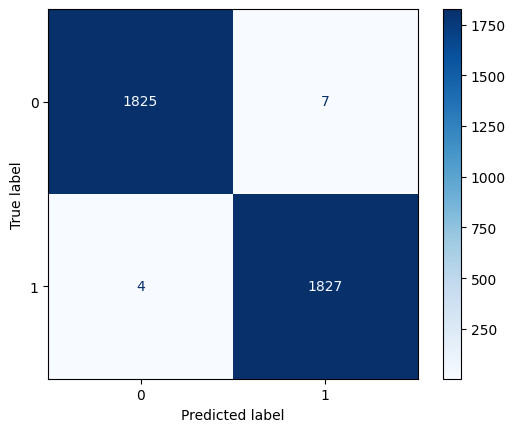

Accuracy:  0.996996996996997
F1:  0.9969986357435198
Precison:  0.9961832061068703
Recall:  0.997815401419989


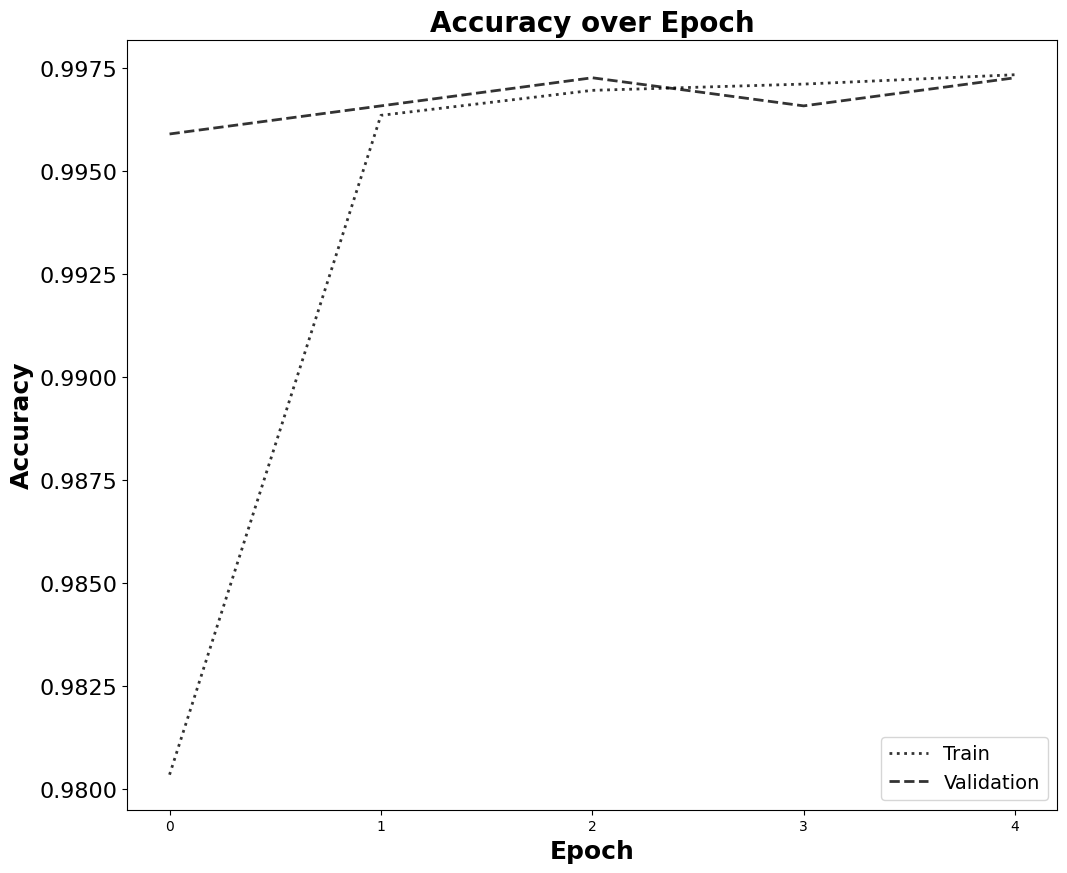

<Figure size 640x480 with 0 Axes>

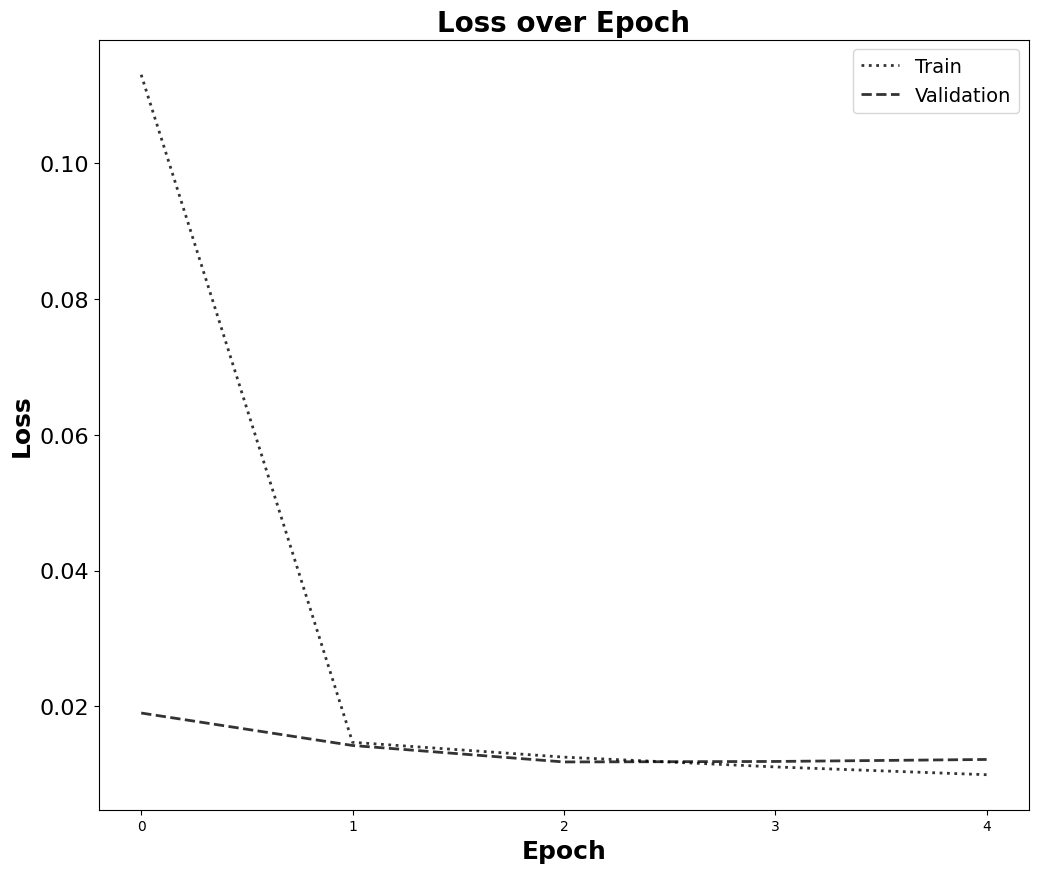

<Figure size 640x480 with 0 Axes>

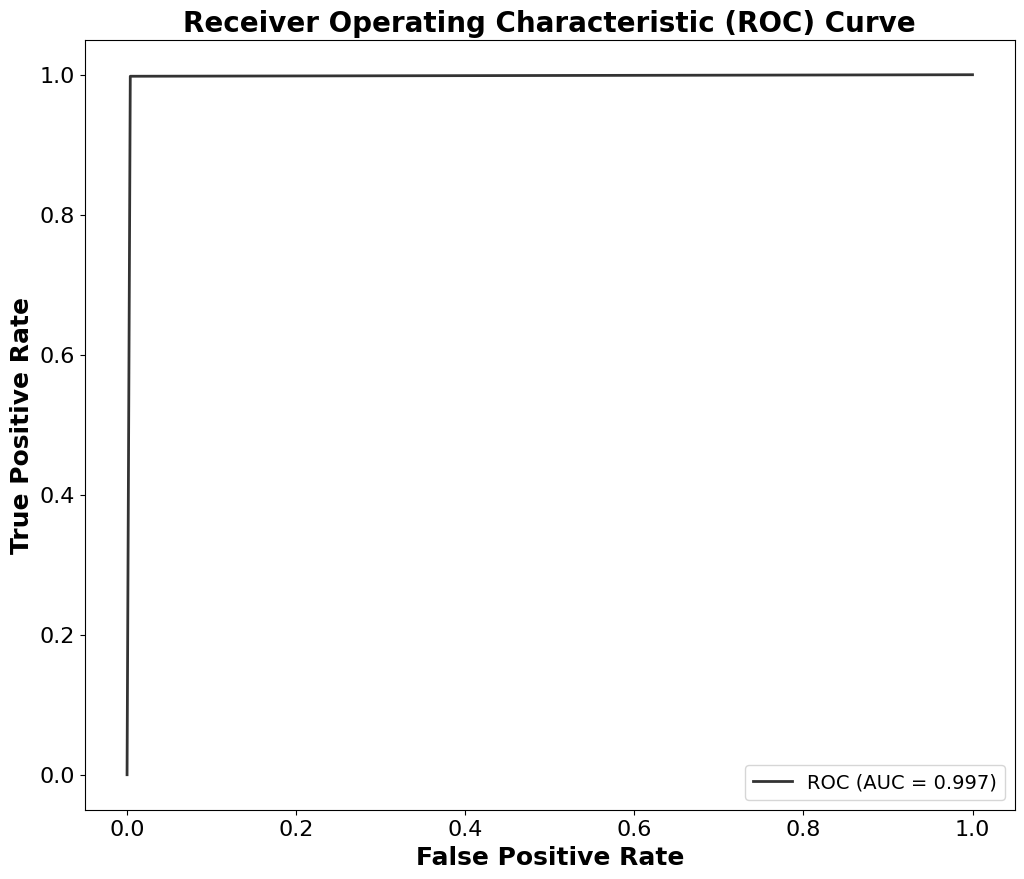

In [27]:
# TRAbID2017
model_3h64n = generate_mlp_model_3_hidden_layers_64_neurons(X_train.shape[1], Y_train)
train_and_evaluate(model_3h64n, X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 64)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5489815 ]
 [0.51509374]
 [0.5130345 ]
 ...
 [0.5717523 ]
 [0.57670534]
 [0.54619145]], shape=(3688, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[6.36979986e-01 2.51408045e-01 1.75006179e-01 ... 0.00000000e+00
  1.09040128e-03 0.00000000e+00]
 [5.26929544e-01 8.35336824e-05 9.79278483e-01 ... 0.00000000e+00
  6.10153579e-03 0.00000000e+00]
 [7.88956989e-01 1.77941572e-05 1.60583337e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.28545859e-01 6.09614644e-05 7.49500019e-04 ... 0.00000000e+00
  2.55496552e-01 0.00000000e+00]
 [5.97439931e-01 9.50669324e-05 1.43375004e-04 ... 0.00000000e+00
  8.93370548e-07 0.00000000e+00]
 [7.78054998e-01 7.90458641e-01 1.77450188e-01 ... 0.00000000e+00
  1.10562902e-03 0.00000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9092 - loss: 0.2789 - val_accuracy: 0.9986 - val_loss: 0.0036
Epoch 2

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 64)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,477 (162.02 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,652 (108.02 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
classification_report
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1688
         1.0     1.0000    1.0000    1.0000      2000

    accuracy                         1.0000      3688
   macro avg     1.0000    1.0000    1.0000      3688
weighted avg     1.0000    1.0000    1.0000      3688

Confusion Matrix:
 [[1688    0]
 [   0 2000]]
labels =  None


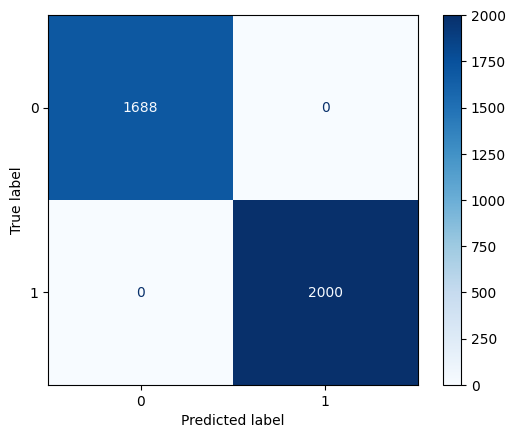

Accuracy:  1.0
F1:  1.0
Precison:  1.0
Recall:  1.0


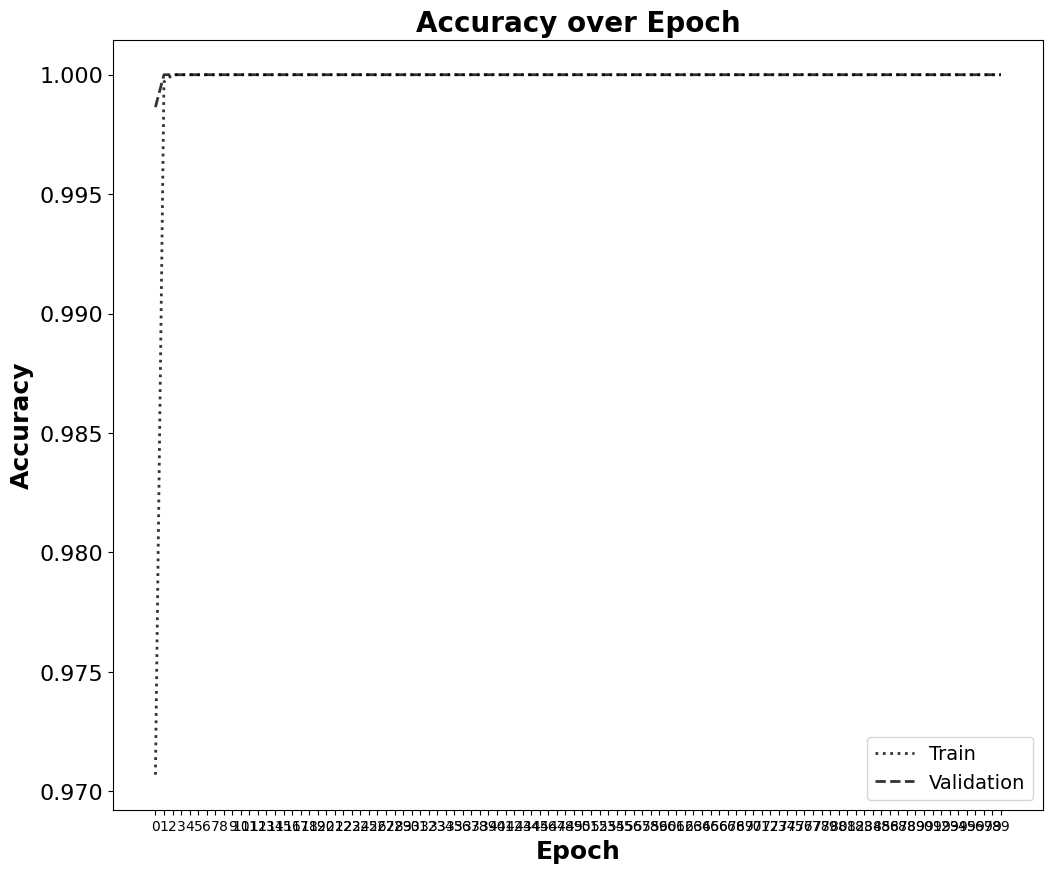

<Figure size 640x480 with 0 Axes>

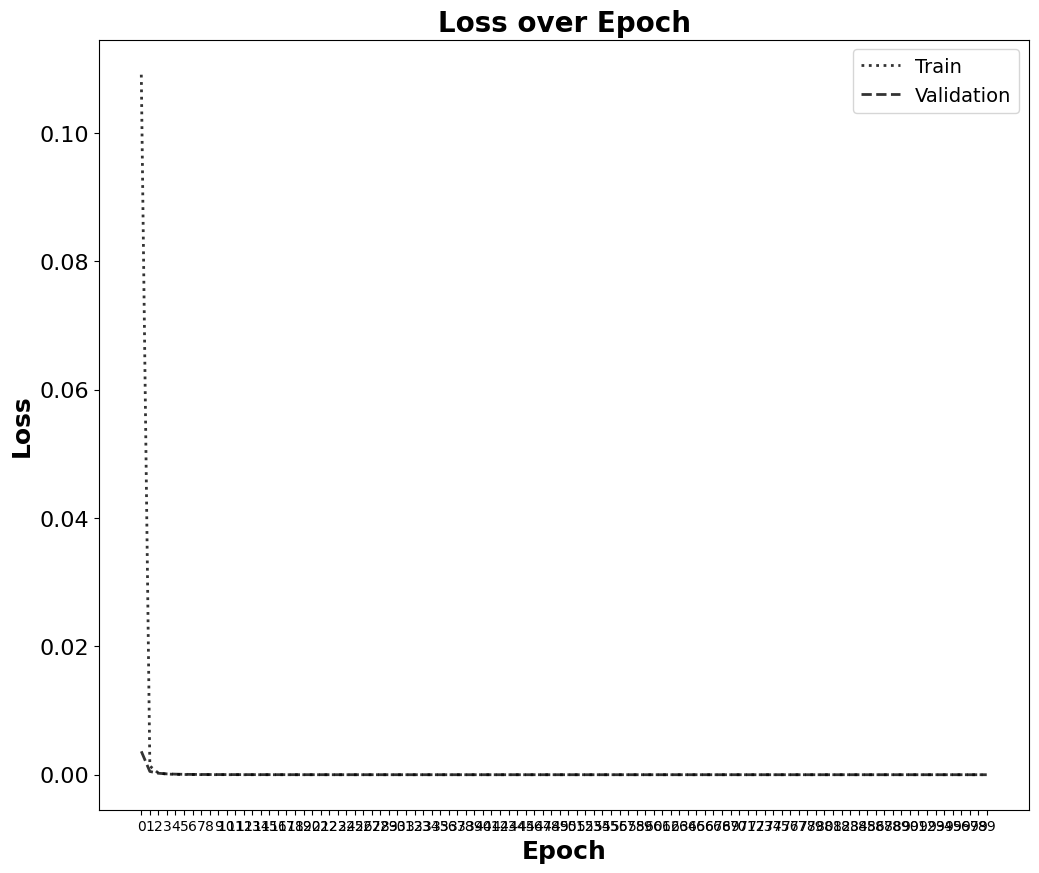

<Figure size 640x480 with 0 Axes>

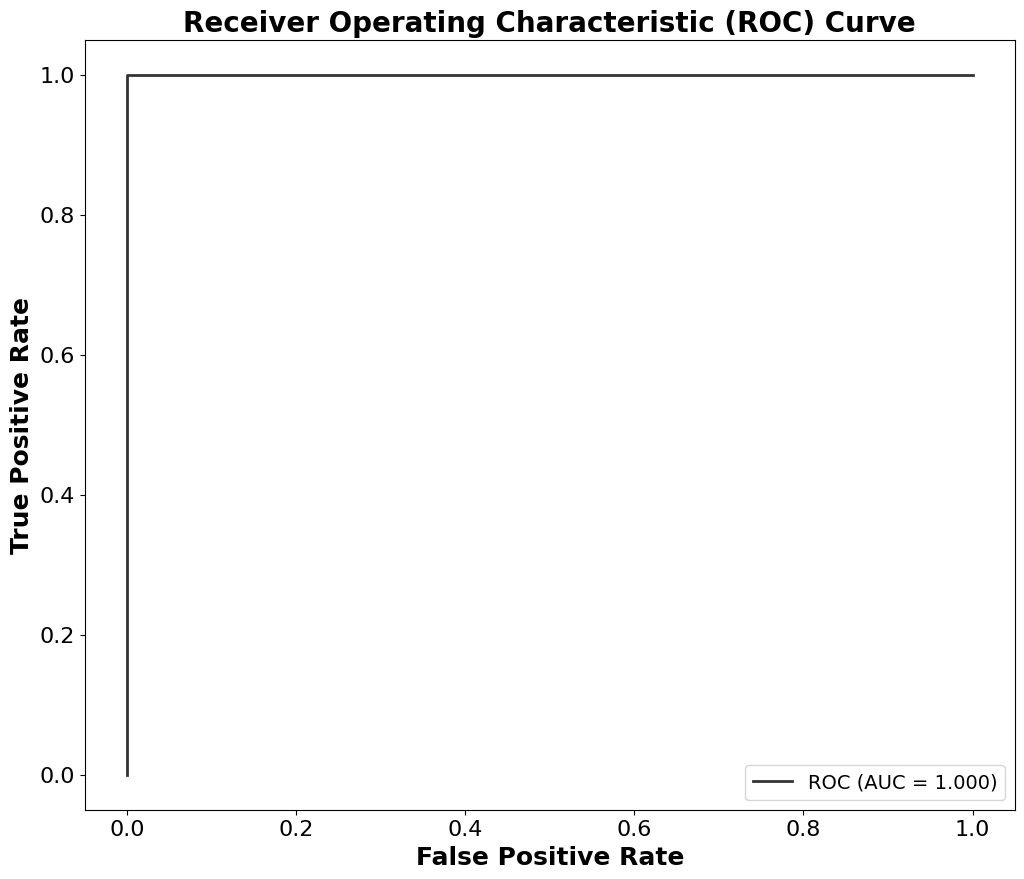

In [28]:
# CSECICIDS2018_improved
csecicids2018_model_3h64n = generate_mlp_model_3_hidden_layers_64_neurons(csecicids2018_X_train.shape[1], csecicids2018_Y_train)
train_and_evaluate(csecicids2018_model_3h64n, csecicids2018_X_train, csecicids2018_Y_train, csecicids2018_X_test, csecicids2018_Y_test)

4 layers with 64 neurons in each layer

In [29]:
# Generate a multilayer perceptron  model or ANN
def generate_mlp_model_4_hidden_layers_64_neurons(input_dim: int, y: np.ndarray):
    n_classes = len(np.unique(y))

    model = Sequential()
    model.add(Dense(units=64,
                    activation='relu',
                    input_shape=(input_dim,))) # layer 1
    model.add(Dense(units=64, activation='relu')) # layer2
    model.add(Dense(units=64, activation='relu')) # layer3
    model.add(Dense(units=64, activation='relu')) # layer4

    if n_classes > 2:  # multiclass with integer labels
        model.add(Dense(units=n_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'  # y must be int labels 0..C-1
    else:  # binary
        model.add(Dense(units=1, activation='sigmoid'))
        loss = 'binary_crossentropy'  # y should be 0/1, float or int

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 64)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5116108 ]
 [0.50502723]
 [0.5059367 ]
 ...
 [0.5045167 ]
 [0.5086559 ]
 [0.5006113 ]], shape=(3663, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[1.095900e-02 4.704205e-01 1.000000e+00 ... 4.800000e-05 0.000000e+00
  1.000000e+00]
 [1.095900e-02 8.662545e-01 1.000000e+00 ... 4.244500e-03 0.000000e+00
  1.000000e+00]
 [1.472600e-02 1.304495e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.794520e-01 8.447700e-01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 7.277945e-01 0.000000e+00 ... 2.400000e-05 0.000000e+00
  0.000000e+00]
 [8.219000e-03 7.155260e-01 1.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9308 - loss: 0.2998 - val_accuracy: 0.9945 - val_loss: 0.0174
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9968 - loss: 0.012

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 64)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,085 (180.02 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,724 (120.02 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
classification_report
               precision    recall  f1-score   support

           0     0.9978    0.9967    0.9973      1832
           1     0.9967    0.9978    0.9973      1831

    accuracy                         0.9973      3663
   macro avg     0.9973    0.9973    0.9973      3663
weighted avg     0.9973    0.9973    0.9973      3663

Confusion Matrix:
 [[1826    6]
 [   4 1827]]
labels =  None


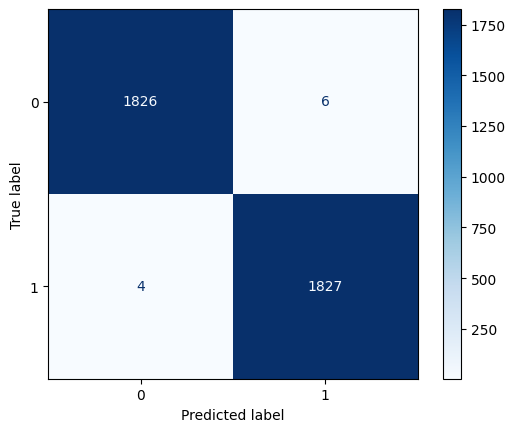

Accuracy:  0.9972699972699973
F1:  0.9972707423580786
Precison:  0.9967266775777414
Recall:  0.997815401419989


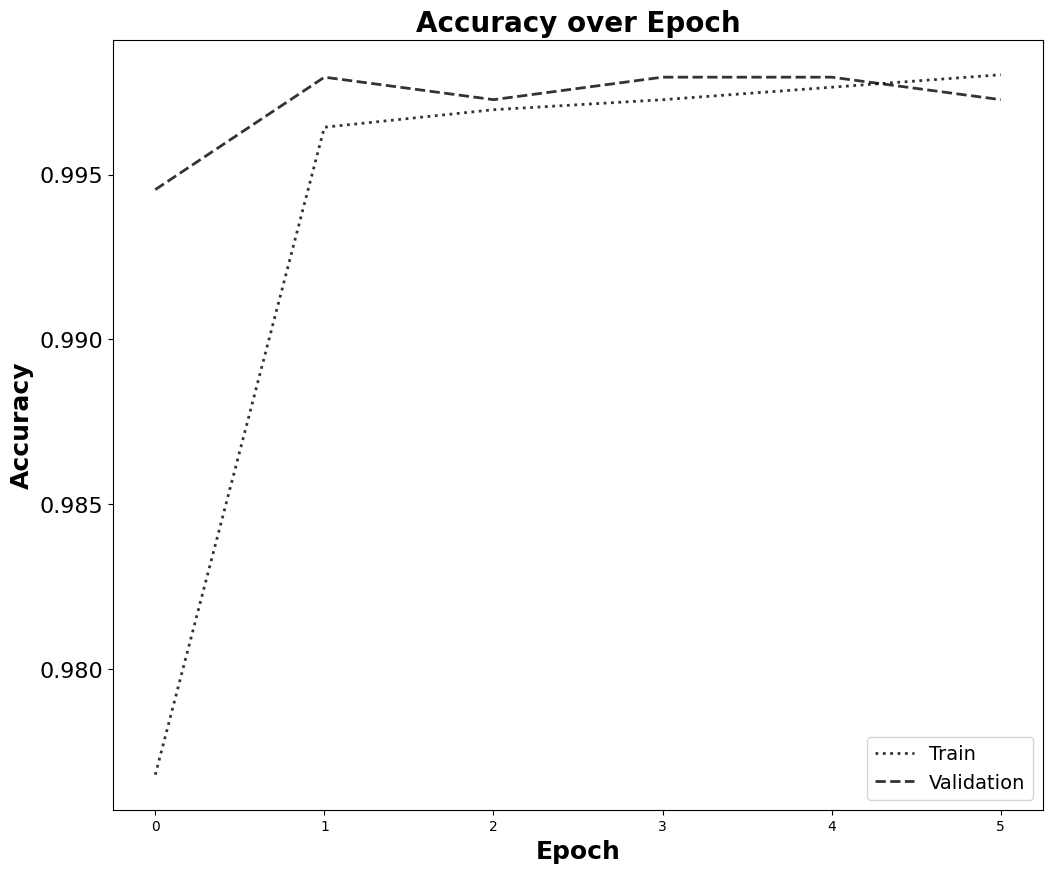

<Figure size 640x480 with 0 Axes>

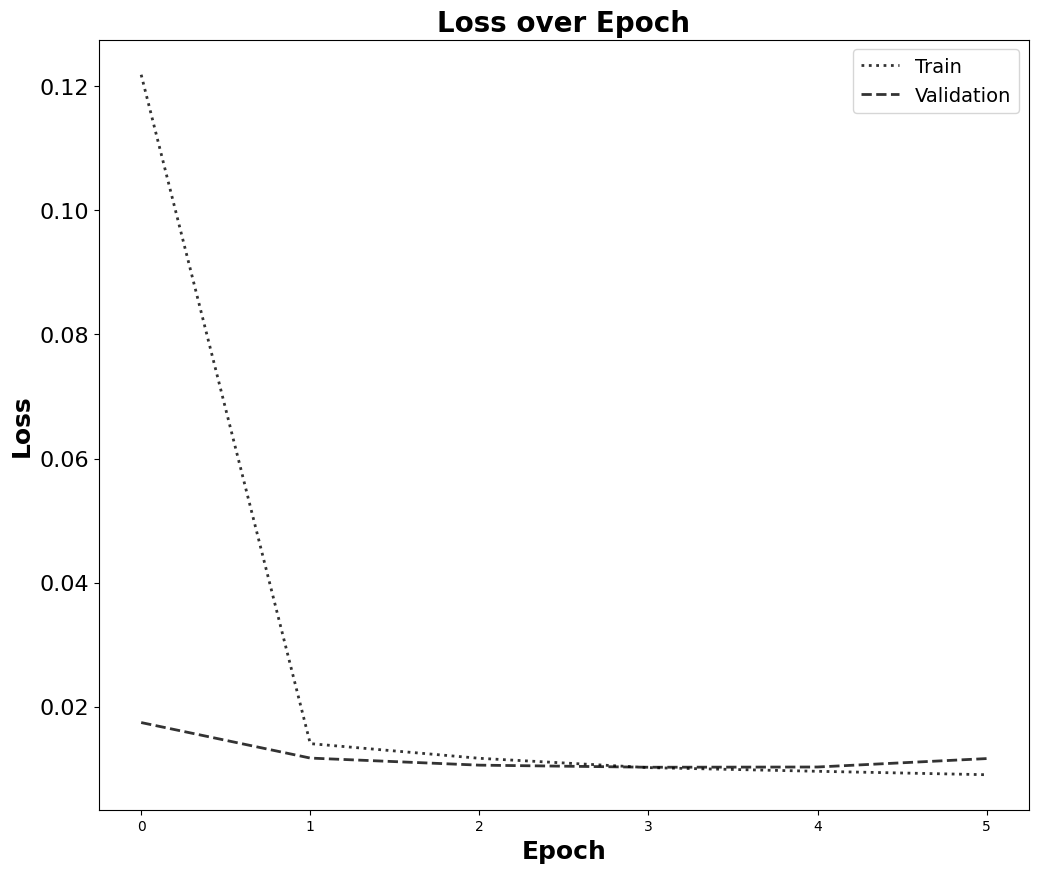

<Figure size 640x480 with 0 Axes>

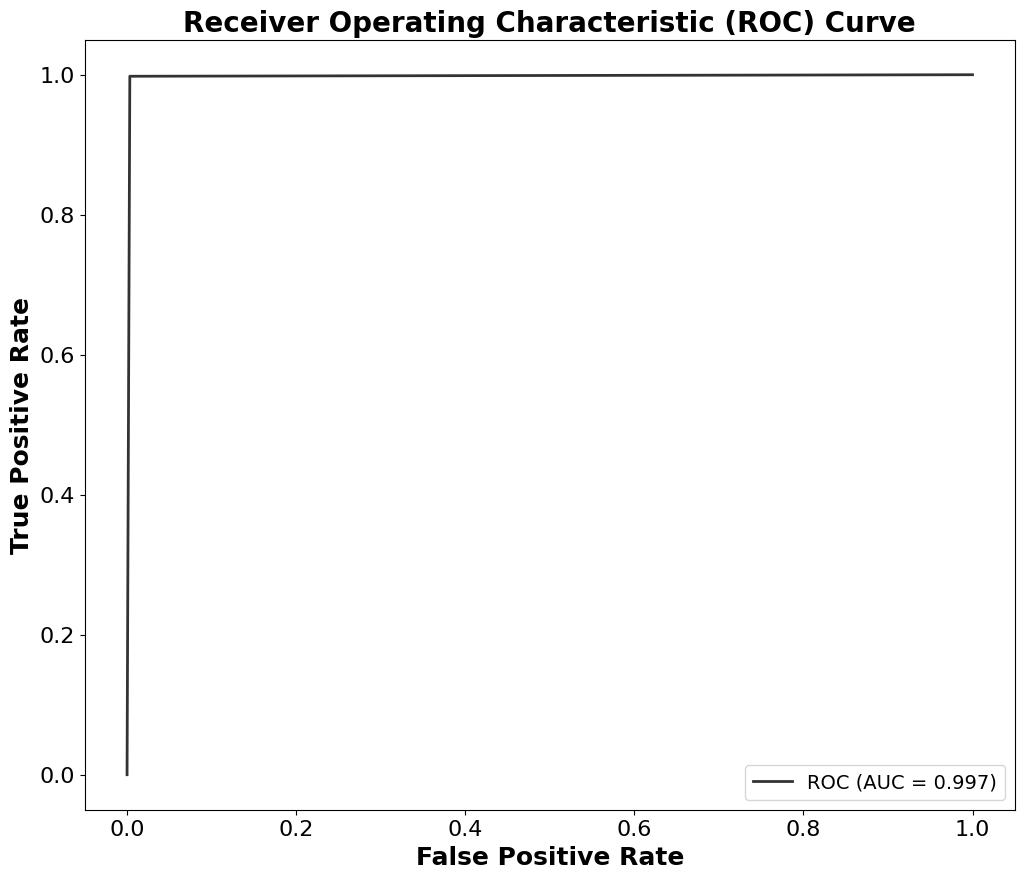

In [30]:
# TRAbID2017
model_4h64n = generate_mlp_model_4_hidden_layers_64_neurons(X_train.shape[1], Y_train)
train_and_evaluate(model_4h64n, X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 64)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Prediction:  tf.Tensor(
[[0.5365116 ]
 [0.51000696]
 [0.50850105]
 ...
 [0.50324184]
 [0.50178534]
 [0.51860726]], shape=(3688, 1), dtype=float32)
X_train: 
 <class 'numpy.ndarray'> [[6.36979986e-01 2.51408045e-01 1.75006179e-01 ... 0.00000000e+00
  1.09040128e-03 0.00000000e+00]
 [5.26929544e-01 8.35336824e-05 9.79278483e-01 ... 0.00000000e+00
  6.10153579e-03 0.00000000e+00]
 [7.88956989e-01 1.77941572e-05 1.60583337e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.28545859e-01 6.09614644e-05 7.49500019e-04 ... 0.00000000e+00
  2.55496552e-01 0.00000000e+00]
 [5.97439931e-01 9.50669324e-05 1.43375004e-04 ... 0.00000000e+00
  8.93370548e-07 0.00000000e+00]
 [7.78054998e-01 7.90458641e-01 1.77450188e-01 ... 0.00000000e+00
  1.10562902e-03 0.00000000e+00]]
Y_train: 
 <class 'numpy.ndarray'> [[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9500 - loss: 0.2446 - val_accuracy: 1.0000 - val_loss: 9.6537e-04
Ep

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 64)             │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,957 (210.77 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,972 (140.52 KB)

None
history keys:  dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Performance when using actual testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
classification_report
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1688
         1.0     1.0000    1.0000    1.0000      2000

    accuracy                         1.0000      3688
   macro avg     1.0000    1.0000    1.0000      3688
weighted avg     1.0000    1.0000    1.0000      3688

Confusion Matrix:
 [[1688    0]
 [   0 2000]]
labels =  None


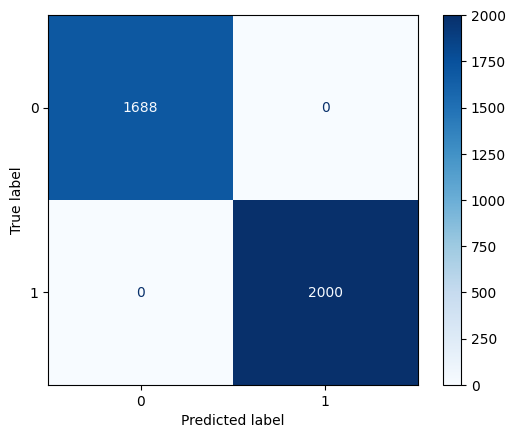

Accuracy:  1.0
F1:  1.0
Precison:  1.0
Recall:  1.0


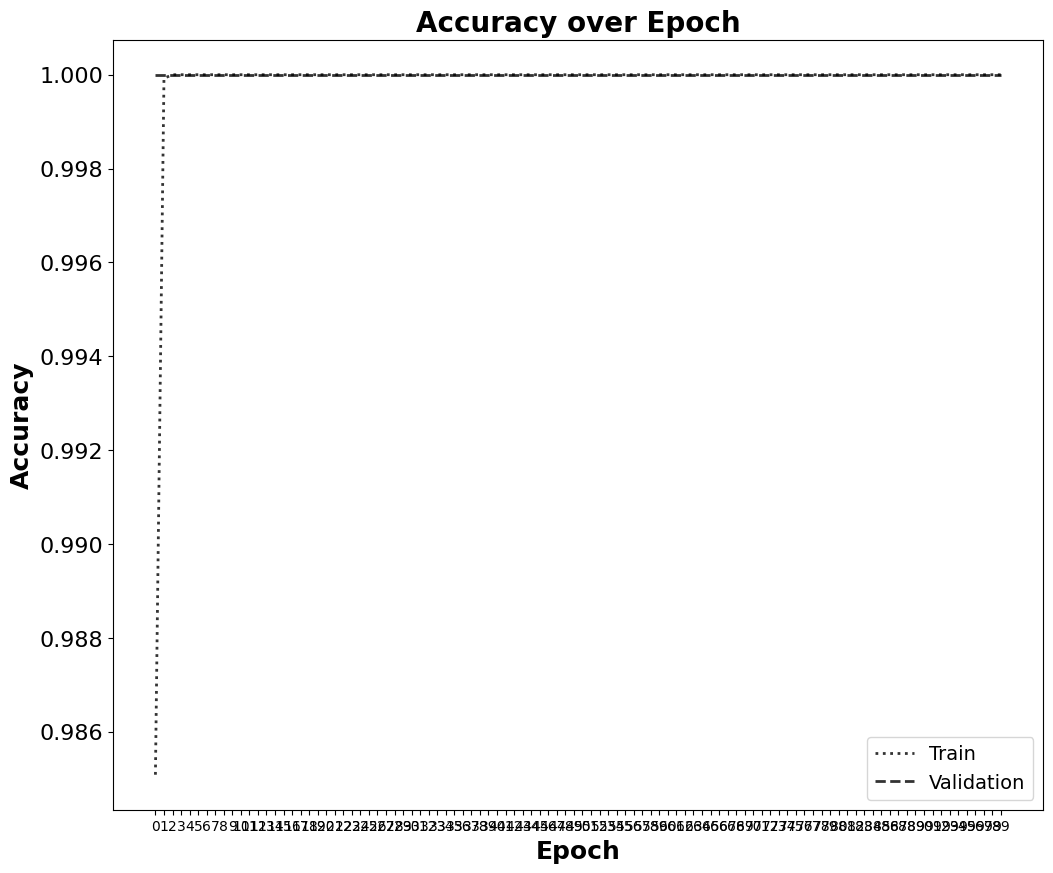

<Figure size 640x480 with 0 Axes>

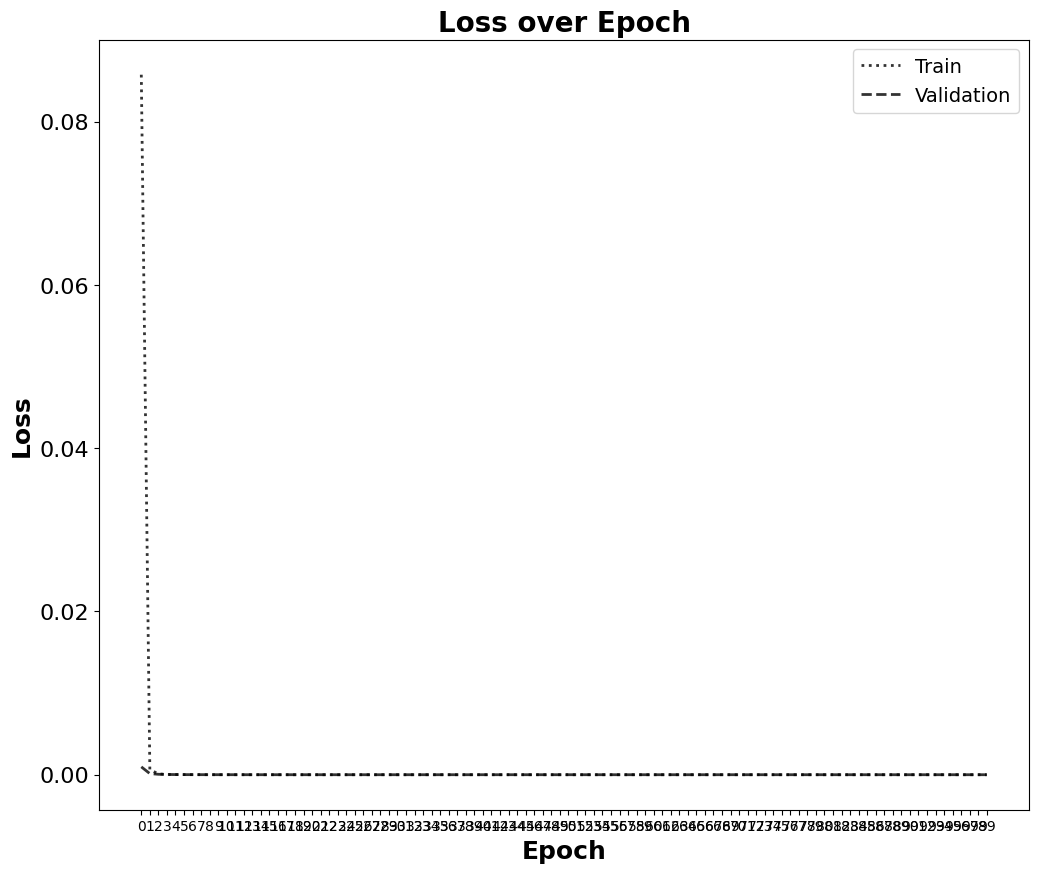

<Figure size 640x480 with 0 Axes>

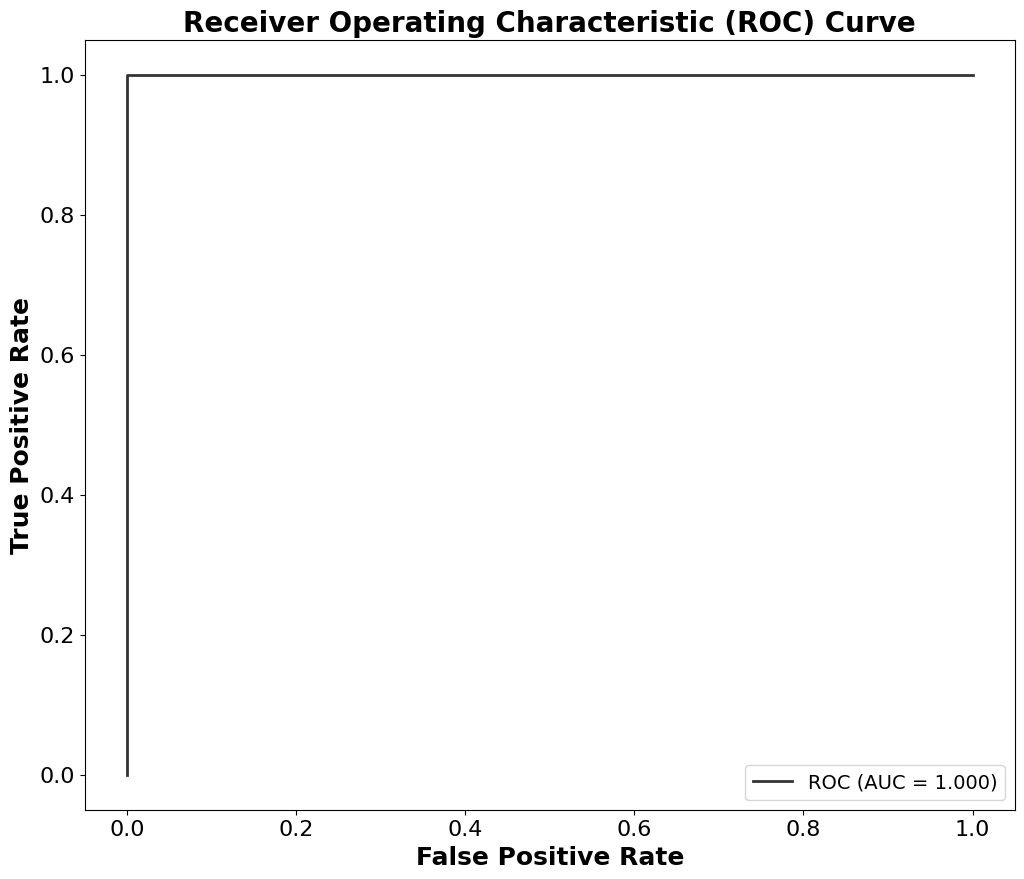

In [31]:
# CSECICIDS2018_improved
csecicids2018_model_4h64n = generate_mlp_model_4_hidden_layers_64_neurons(csecicids2018_X_train.shape[1], csecicids2018_Y_train)
train_and_evaluate(csecicids2018_model_4h64n, csecicids2018_X_train, csecicids2018_Y_train, csecicids2018_X_test, csecicids2018_Y_test)

## Generate adversarial samples for all test datapoints (JSMA)

In [32]:
from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import KerasClassifier

In [33]:
# Build adversarials: modify only class-0 samples; leave class-1 unchanged
# indices of samples whose true class == 0
def label_to_class(y):
    if np.ndim(y) == 0 or (np.ndim(y) == 1 and y.shape[0] == 1):
        return int(y)
    return int(np.argmax(y))


def generate_adv_samples(model, X_test, Y_test):
    batch_size = 32
    # 1) Ensure inputs are float32 in [0, 1]
    X_test = X_test.astype("float32")

    # 2) Wrap binary model to expose two outputs [1 - p, p]
    inp = Input(shape=X_test.shape[1:], dtype=tf.float32)
    raw = model(inp)  # builds the Sequential if it wasn't called yet

    # Determine output width robustly
    n_out = raw.shape[-1] if hasattr(raw, "shape") else tf.keras.backend.int_shape(raw)[-1]

    if n_out == 1:
        # If last activation is linear, add sigmoid; otherwise assume it's already sigmoid
        last_act = getattr(model.layers[-1], "activation", tf.keras.activations.linear)
        p = tf.keras.activations.sigmoid(raw) if last_act == tf.keras.activations.linear else raw
        two = Concatenate(axis=-1)([Lambda(lambda t: 1.0 - t)(p), p])  # shape: (None, 2)
    else:
        # Already multi-class; keep as-is
        two = raw

    wrapped_model = Model(inputs=inp, outputs=two)

    # 3) ART classifier: FORCE nb_classes=2 so JSMA never sees a single class
    classifier = KerasClassifier(model=wrapped_model,
                                clip_values=(0.0, 1.0))

    # 4) JSMA attack
    attack = SaliencyMapMethod(classifier=classifier, theta=1.0, gamma=0.1, verbose=False)

    # 5) Target vector: class 1 (shape (1, 2))
    y_target_vec = np.array([[0.0, 1.0]], dtype=np.float32)


    true_classes = np.array([label_to_class(y) for y in Y_test], dtype=int)
    indices_to_attack = np.where(true_classes == 0)[0]
    X_adv = X_test.copy()
    for start in tqdm(range(0, len(indices_to_attack), batch_size)):
        # if start > 100:
        #     break
        # Accept scalar labels or one-hot labels
        batch_inds = indices_to_attack[start:start + batch_size]
        try:
            x_batch = X_test[batch_inds].astype(np.float32)            # shape: (B, ...)
        except:
            x_batch = X_test.iloc[batch_inds].astype(np.float32).values

        y_batch = np.tile(y_target_vec, (x_batch.shape[0], 1)).astype(np.float32)  # shape: (B, nb_classes)

        adv_batch = attack.generate(x=x_batch, y=y_batch)          # returns (B, ...)
        try:
            X_adv[batch_inds] = adv_batch
        except:
            X_adv.iloc[batch_inds, :] = adv_batch
    return X_adv


### MLP Evasion Attack

Attack the MLP model training and testing with the TRAbID2017 dataset

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 58/58 [05:37<00:00,  5.81s/it]

Performance when using adversarial testing instances
100/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
classification_report
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1832
           1     0.4993    0.9978    0.6656      1831

    accuracy                         0.4988      3663
   macro avg     0.2497    0.4989    0.3328      3663
weighted avg     0.2496    0.4988    0.3327      3663

Confusion Matrix:
 [[   0 1832]
 [   4 1827]]
labels =  None


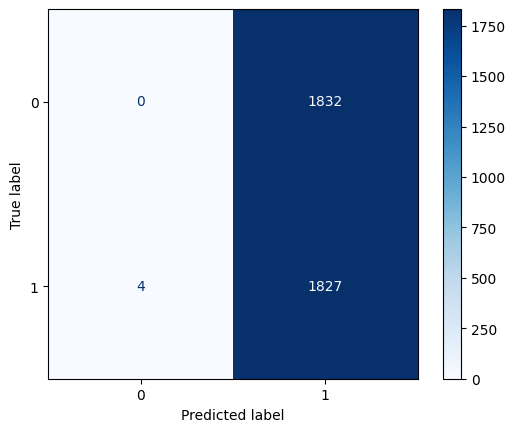

Accuracy:  0.4987714987714988
F1:  0.6655737704918033
Precison:  0.4993167532112599
Recall:  0.997815401419989


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [34]:
# TRAbID2017
X_adv_mlp = generate_adv_samples(self_defined_model, X_test, Y_test)
# ============== Evaluation of the model with adversarial instances ==============
print("Performance when using adversarial testing instances")
model_eval(self_defined_model, X_adv_mlp, Y_test)

Attack the MLP model training and testing with the CSECICIDS2018_improved dataset

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 53/53 [11:01<00:00, 12.48s/it]

Performance when using adversarial testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

         0.0     1.0000    0.0379    0.0731      1688
         1.0     0.5519    1.0000    0.7112      2000

    accuracy                         0.5597      3688
   macro avg     0.7759    0.5190    0.3921      3688
weighted avg     0.7570    0.5597    0.4191      3688

Confusion Matrix:
 [[  64 1624]
 [   0 2000]]
labels =  None


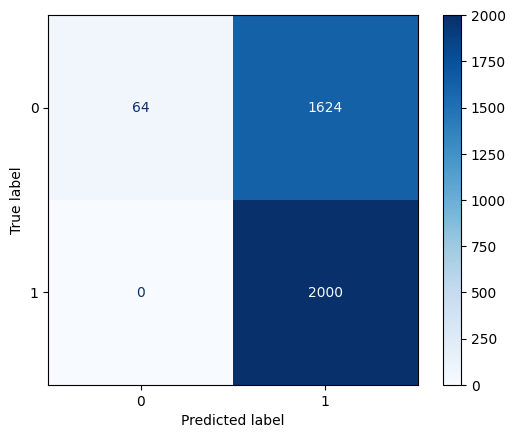

Accuracy:  0.559652928416486
F1:  0.7112375533428165
Precison:  0.5518763796909493
Recall:  1.0


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [35]:
csecicids2018_X_adv_mlp = generate_adv_samples(csecicids2018_self_defined_model, csecicids2018_X_test, csecicids2018_Y_test)
print("Performance when using adversarial testing instances")
model_eval(csecicids2018_self_defined_model, csecicids2018_X_adv_mlp, csecicids2018_Y_test)

### More MLPs

Three-hidden-layer MLP model  

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 58/58 [05:58<00:00,  6.19s/it]

Performance when using adversarial testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1832
           1     0.4993    0.9978    0.6656      1831

    accuracy                         0.4988      3663
   macro avg     0.2497    0.4989    0.3328      3663
weighted avg     0.2496    0.4988    0.3327      3663

Confusion Matrix:
 [[   0 1832]
 [   4 1827]]
labels =  None


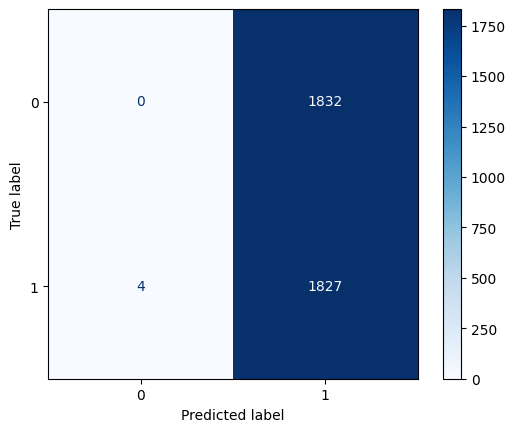

Accuracy:  0.4987714987714988
F1:  0.6655737704918033
Precison:  0.4993167532112599
Recall:  0.997815401419989


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [36]:
# Dataset: The TRAbID2017 dataset
X_adv_mlp_3h = generate_adv_samples(model_3_hidden_layers, X_test, Y_test)
print("Performance when using adversarial testing instances")
model_eval(model_3_hidden_layers, X_adv_mlp_3h, Y_test)

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 53/53 [18:53<00:00, 21.39s/it]

Performance when using adversarial testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


classification_report
               precision    recall  f1-score   support

         0.0     1.0000    0.1570    0.2714      1688
         1.0     0.5843    1.0000    0.7376      2000

    accuracy                         0.6142      3688
   macro avg     0.7921    0.5785    0.5045      3688
weighted avg     0.7746    0.6142    0.5242      3688

Confusion Matrix:
 [[ 265 1423]
 [   0 2000]]
labels =  None


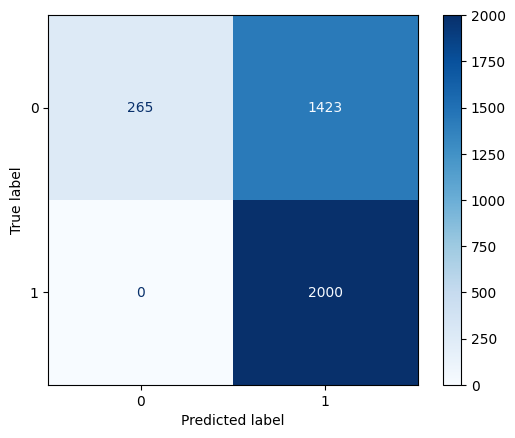

Accuracy:  0.6141540130151844
F1:  0.7375991148810621
Precison:  0.5842827928717499
Recall:  1.0


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [37]:
# Dataset: The CSECICIDS2018_improved dataset
csecicids2018_X_adv_mlp_3h = generate_adv_samples(csecicids2018_model_3_hidden_layers, csecicids2018_X_test, csecicids2018_Y_test)
print("Performance when using adversarial testing instances")
model_eval(csecicids2018_model_3_hidden_layers, csecicids2018_X_adv_mlp_3h, csecicids2018_Y_test)

Model: Four-hidden-layer MLP model  

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 58/58 [07:21<00:00,  7.61s/it]

Performance when using adversarial testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1832
           1     0.4993    0.9978    0.6656      1831

    accuracy                         0.4988      3663
   macro avg     0.2497    0.4989    0.3328      3663
weighted avg     0.2496    0.4988    0.3327      3663

Confusion Matrix:
 [[   0 1832]
 [   4 1827]]
labels =  None


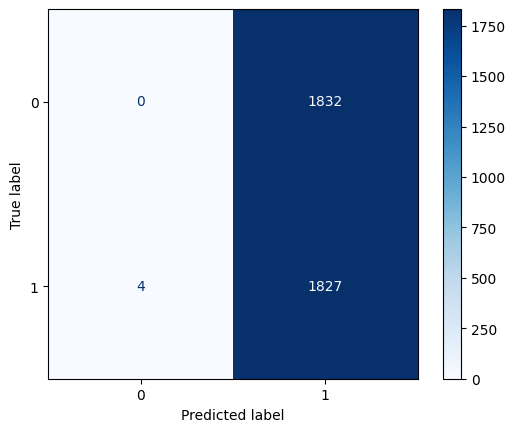

Accuracy:  0.4987714987714988
F1:  0.6655737704918033
Precison:  0.4993167532112599
Recall:  0.997815401419989


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [38]:
# Dataset: The TRAbID2017 dataset
X_adv_mlp_4h = generate_adv_samples(model_4_hidden_layers, X_test, Y_test)
print("Performance when using adversarial testing instances")
model_eval(model_4_hidden_layers, X_adv_mlp_4h, Y_test)

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 53/53 [12:35<00:00, 14.26s/it]

Performance when using adversarial testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      1688
         1.0     0.5423    1.0000    0.7032      2000

    accuracy                         0.5423      3688
   macro avg     0.2711    0.5000    0.3516      3688
weighted avg     0.2941    0.5423    0.3814      3688

Confusion Matrix:
 [[   0 1688]
 [   0 2000]]
labels =  None


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


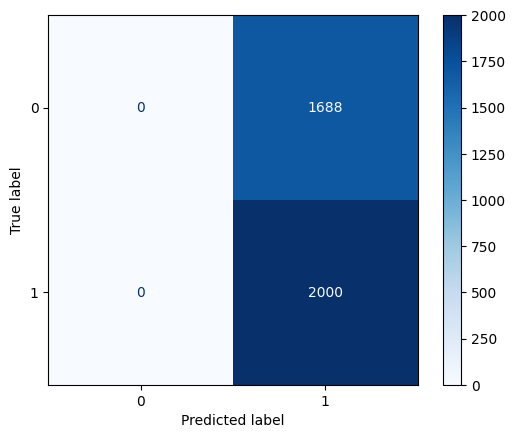

Accuracy:  0.5422993492407809
F1:  0.7032348804500703
Precison:  0.5422993492407809
Recall:  1.0


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [39]:
# Dataset: The CSECICIDS2018_improved dataset
csecicids2018_X_adv_mlp_4h = generate_adv_samples(csecicids2018_model_4_hidden_layers, csecicids2018_X_test, csecicids2018_Y_test)
print("Performance when using adversarial testing instances")
model_eval(csecicids2018_model_4_hidden_layers, csecicids2018_X_adv_mlp_4h, csecicids2018_Y_test)

Model: Two-hidden-layer & 64 neurons in each layer  

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 58/58 [05:30<00:00,  5.70s/it]

Performance when using adversarial testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1832
           1     0.4993    0.9978    0.6656      1831

    accuracy                         0.4988      3663
   macro avg     0.2497    0.4989    0.3328      3663
weighted avg     0.2496    0.4988    0.3327      3663

Confusion Matrix:
 [[   0 1832]
 [   4 1827]]
labels =  None


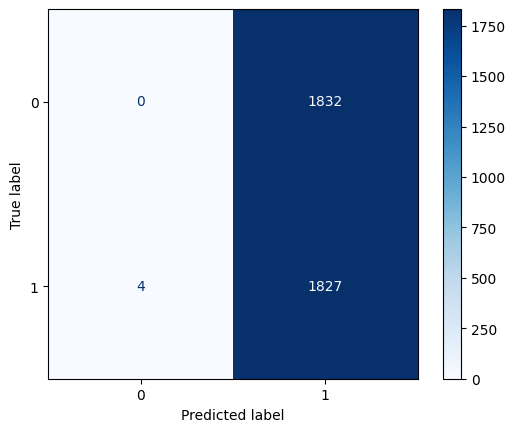

Accuracy:  0.4987714987714988
F1:  0.6655737704918033
Precison:  0.4993167532112599
Recall:  0.997815401419989


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [40]:
# Dataset: The TRAbID2017 dataset
X_adv_mlp_2h64n = generate_adv_samples(model_2h64n, X_test, Y_test)
print("Performance when using adversarial testing instances")
model_eval(model_2h64n, X_adv_mlp_2h64n, Y_test)

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 53/53 [11:11<00:00, 12.67s/it]

Performance when using adversarial testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      1688
         1.0     0.5423    1.0000    0.7032      2000

    accuracy                         0.5423      3688
   macro avg     0.2711    0.5000    0.3516      3688
weighted avg     0.2941    0.5423    0.3814      3688

Confusion Matrix:
 [[   0 1688]
 [   0 2000]]
labels =  None


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


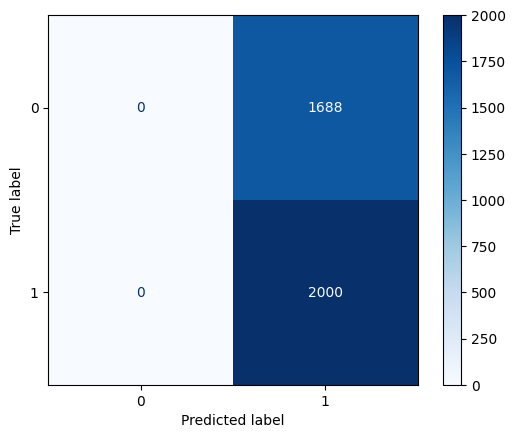

Accuracy:  0.5422993492407809
F1:  0.7032348804500703
Precison:  0.5422993492407809
Recall:  1.0


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [41]:
# Dataset: The CSECICIDS2018_improved dataset
csecicids2018_X_adv_mlp_2h64n = generate_adv_samples(csecicids2018_model_2h64n, csecicids2018_X_test, csecicids2018_Y_test)
print("Performance when using adversarial testing instances")
model_eval(csecicids2018_model_2h64n, csecicids2018_X_adv_mlp_2h64n, csecicids2018_Y_test)

Model: Three-hidden-layer & 64 neurons in each layer  

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 58/58 [06:31<00:00,  6.75s/it]

Performance when using adversarial testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


classification_report
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1832
           1     0.4993    0.9978    0.6656      1831

    accuracy                         0.4988      3663
   macro avg     0.2497    0.4989    0.3328      3663
weighted avg     0.2496    0.4988    0.3327      3663

Confusion Matrix:
 [[   0 1832]
 [   4 1827]]
labels =  None


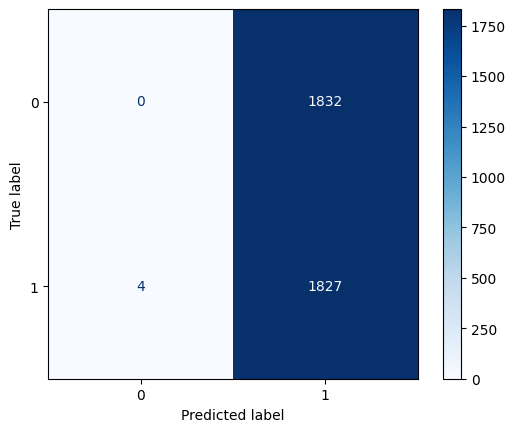

Accuracy:  0.4987714987714988
F1:  0.6655737704918033
Precison:  0.4993167532112599
Recall:  0.997815401419989


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [42]:
# Dataset: The TRAbID2017 dataset
X_adv_mlp_3h64n = generate_adv_samples(model_3h64n, X_test, Y_test)
print("Performance when using adversarial testing instances")
model_eval(model_3h64n, X_adv_mlp_3h64n, Y_test)

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 53/53 [11:08<00:00, 12.62s/it]

Performance when using adversarial testing instances
 92/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
classification_report
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      1688
         1.0     0.5423    1.0000    0.7032      2000

    accuracy                         0.5423      3688
   macro avg     0.2711    0.5000    0.3516      3688
weighted avg     0.2941    0.5423    0.3814      3688

Confusion Matrix:
 [[   0 1688]
 [   0 2000]]
labels =  None


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


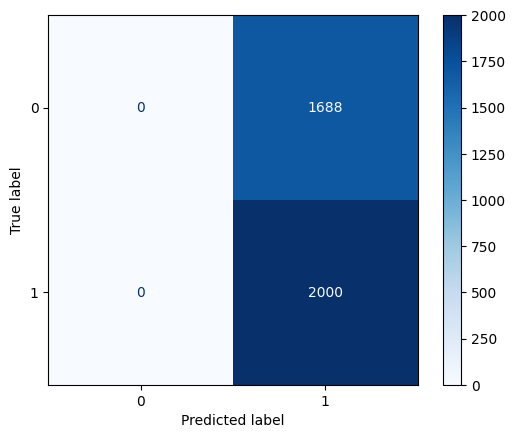

Accuracy:  0.5422993492407809
F1:  0.7032348804500703
Precison:  0.5422993492407809
Recall:  1.0


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [43]:
# Dataset: The CSECICIDS2018_improved dataset
csecicids2018_X_adv_mlp_3h64n = generate_adv_samples(csecicids2018_model_3h64n, csecicids2018_X_test, csecicids2018_Y_test)
print("Performance when using adversarial testing instances")
model_eval(csecicids2018_model_3h64n, csecicids2018_X_adv_mlp_3h64n, csecicids2018_Y_test)

Model: Four-hidden-layer & 64 neurons in each layer  

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 58/58 [07:03<00:00,  7.31s/it]

Performance when using adversarial testing instances
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1832
           1     0.4993    0.9978    0.6656      1831

    accuracy                         0.4988      3663
   macro avg     0.2497    0.4989    0.3328      3663
weighted avg     0.2496    0.4988    0.3327      3663

Confusion Matrix:
 [[   0 1832]
 [   4 1827]]
labels =  None


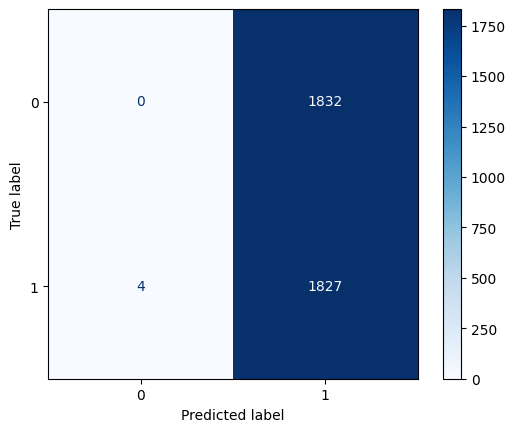

Accuracy:  0.4987714987714988
F1:  0.6655737704918033
Precison:  0.4993167532112599
Recall:  0.997815401419989


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [44]:
# Datset: The TRAbID2017 dataset
X_adv_mlp_4h64n = generate_adv_samples(model_4h64n, X_test, Y_test)
print("Performance when using adversarial testing instances")
model_eval(model_4h64n, X_adv_mlp_4h64n, Y_test)

/tmp/ipython-input-1382613301.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(y)
100%|██████████| 53/53 [14:17<00:00, 16.18s/it]

Performance when using adversarial testing instances
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


classification_report
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      1688
         1.0     0.5423    1.0000    0.7032      2000

    accuracy                         0.5423      3688
   macro avg     0.2711    0.5000    0.3516      3688
weighted avg     0.2941    0.5423    0.3814      3688

Confusion Matrix:
 [[   0 1688]
 [   0 2000]]
labels =  None


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


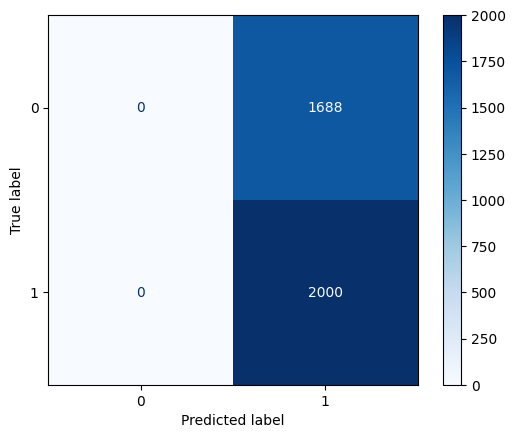

Accuracy:  0.5422993492407809
F1:  0.7032348804500703
Precison:  0.5422993492407809
Recall:  1.0


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [50]:
# Dataset: The CSECICIDS2018_improved dataset
csecicids2018_X_adv_mlp_4h64n = generate_adv_samples(csecicids2018_model_4h64n, csecicids2018_X_test, csecicids2018_Y_test)
print("Performance when using adversarial testing instances")
model_eval(csecicids2018_model_4h64n, csecicids2018_X_adv_mlp_4h64n, csecicids2018_Y_test)

# Disconnect

In [51]:
from google.colab import runtime
from time import sleep

# Wait for a minute.
sleep(60)

# Disconnect runtime.
runtime.unassign()
print("disconnected")

disconnected
